# 0. INTRODUCTION: MODEL BUILDING SECTIONS

# 1. Load Training and Testing Dataset

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from imblearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
full_df = pd.read_csv('Data/full_df.csv')
calibration_df = pd.read_csv('Data/calibration.csv')
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')

In [3]:
print('Shape of calibration dataset: ', calibration_df.shape)
print('Shape of training dataset: ', train_df.shape)
print('Shape of testing dataset: ', test_df.shape)
print('Shape of full dataset: ', full_df.shape)
print(f'\n% Training from full dataset: {100*len(train_df)/len(full_df):.2f}%')

Shape of calibration dataset:  (489, 15)
Shape of training dataset:  (3204, 15)
Shape of testing dataset:  (880, 15)
Shape of full dataset:  (4888, 15)

% Training from full dataset: 65.55%


In [4]:
full_df.head()

CustomerID  ProdTaken   Age  CompanyInvited  CityTier  DurationOfPitch  \
0      200000          1  41.0               0         3              6.0   
1      200001          0  49.0               1         1             14.0   
2      200002          1  37.0               0         1              8.0   
3      200003          0  33.0               1         1              9.0   
4      200004          0   NaN               0         1              8.0   

       Occupation  GenderMale  NumberOfFollowups  PreferredPropertyStar  \
0          Others           0                3.0                    3.0   
1          Others           1                4.0                    4.0   
2          Others           1                4.0                    3.0   
3          Others           0                3.0                    3.0   
4  Small Business           1                3.0                    4.0   

  MaritalStatus  HasPassport  PitchSatisfactionScore Designation  \
0     Unmarried            1                       2     Manager   
1      Divorced            0                       3     Manager   
2     Unmarried            1                       3   Executive   
3      Divorced            1                       5   Executive   
4      Divorced            0                       5   Executive   

   MonthlyIncome  
0        20993.0  
1        20130.0  
2        17090.0  
3        17909.0  
4        18468.0

# 2. Define X_train and y_train

In [5]:
#statification keys
strat_key = ['ProdTaken', 'CompanyInvited']
id_key = ['CustomerID']
drop_cols = strat_key+id_key

In [6]:
X_cal = calibration_df.drop(columns=drop_cols).copy()
y_cal = calibration_df.ProdTaken.copy()

X_train = train_df.drop(columns=drop_cols).copy()
y_train = train_df.ProdTaken.copy()

X_test = test_df.drop(columns=drop_cols).copy()
y_test = test_df.ProdTaken.copy()

In [7]:
#for calibration set
print('X_cal shape: ', X_cal.shape)
print('y_cal shape: ', y_cal.shape)

#for train set
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

#for test set
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_cal shape:  (489, 12)
y_cal shape:  (489,)
X_train shape:  (3204, 12)
y_train shape:  (3204,)
X_test shape:  (880, 12)
y_test shape:  (880,)


# 3. Model Building Steps

Data Cleaning is Essensial Steps in Machine Learning Preprocessing. The steps of Data Cleaning in this Project includings:

## 3.1. Missing Values Imputations Step
to input missing values, we need to check the Features that has missing values in it. And then we can decide which strategy to treat with missing data.

### 3.1.1 Create Function to Check Null Values

In [8]:
def check_null(df, display_only_null=True):
    null = pd.concat([df.isna().sum(), 100*df.isna().sum()/len(df)], axis=1) \
                  .rename(columns = {0:'QTY Null', 1:'Percent Null'})

    if display_only_null:
        null =  null[null['QTY Null'] > 0]

    #display
    if len(null)==0:
        print(f"There's No Null Values within DataFrame")
    else:
        return null

In [9]:
check_null(train_df)

QTY Null  Percent Null
Age                     157      4.900125
DurationOfPitch         177      5.524345
NumberOfFollowups        31      0.967541
MonthlyIncome           157      4.900125

In [10]:
check_null(test_df)

QTY Null  Percent Null
Age                          40      4.545455
DurationOfPitch              50      5.681818
NumberOfFollowups            10      1.136364
PreferredPropertyStar         2      0.227273
MonthlyIncome                53      6.022727

we can see that missing values are for numerical data, the QTY of null are small (only 5,2% at maximum), and the most important is the doesn't follow normal distribution. with this, we can do simple imputation of missing values with median.

### 3.1.2. Create Custom Imputation Class

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

In [12]:
#create class for adding features
class ColumnImputer(TransformerMixin, BaseEstimator):
    """
    Encode Columns
    """
    #initialize function
    def __init__(self,
                 steps=[],
                 remainder='passthrough'):
        
        super().__init__()
        self.steps = steps
        self.remainder = remainder

    #fit somethings
    def fit(self, X, y=None):
        X_train = X.copy()
        self.cl = ColumnTransformer(self.steps,
                                    remainder=self.remainder)
        self.cl.fit(X_train)
        return self

    #transform column
    def transform(self, X, y=None):
        X_test = X.copy()
        
        columns = [col.split('__')[-1] for col in self.cl.get_feature_names_out()]
        
        return pd.DataFrame(self.cl.transform(X_test), columns = columns)

### 3.1.3. Test Custom Imputation Class

In [13]:
nan_col = ['Age',
           'DurationOfPitch',
           'NumberOfFollowups',
           'PreferredPropertyStar',
           'MonthlyIncome']

imputer = ColumnImputer([('median_imputer',
                          SimpleImputer(strategy='median'),
                          nan_col)])

In [14]:
res_train = imputer.fit_transform(X_train)
res_train.head()

Age DurationOfPitch NumberOfFollowups PreferredPropertyStar MonthlyIncome  \
0  30.0            24.0               3.0                   3.0       17632.0   
1  30.0             9.0               4.0                   4.0       21858.0   
2  27.0            26.0               3.0                   3.0       24981.0   
3  34.0            10.0               4.0                   4.0       20955.0   
4  38.0            26.0               4.0                   3.0       24446.0   

  CityTier Occupation GenderMale MaritalStatus HasPassport  \
0        1     Others          0     Unmarried           0   
1        1     Others          0      Divorced           0   
2        3     Others          0     Unmarried           0   
3        2     Others          1       Married           1   
4        1     Others          1       Married           0   

  PitchSatisfactionScore Designation  
0                      2   Executive  
1                      5   Executive  
2                      1     Manager  
3                      5   Executive  
4                      1     Manager

In [15]:
res_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     3204 non-null   object
 1   DurationOfPitch         3204 non-null   object
 2   NumberOfFollowups       3204 non-null   object
 3   PreferredPropertyStar   3204 non-null   object
 4   MonthlyIncome           3204 non-null   object
 5   CityTier                3204 non-null   object
 6   Occupation              3204 non-null   object
 7   GenderMale              3204 non-null   object
 8   MaritalStatus           3204 non-null   object
 9   HasPassport             3204 non-null   object
 10  PitchSatisfactionScore  3204 non-null   object
 11  Designation             3204 non-null   object
dtypes: object(12)
memory usage: 300.5+ KB


In [16]:
check_null(res_train)

There's No Null Values within DataFrame


## 3.2 Feature Balancing Step

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC

In [18]:
#define ordinal column to be encoded and resampled
cat_col_smotenc = [
    'PreferredPropertyStar',
    'CityTier',
    'Occupation',
    'MaritalStatus',
    'HasPassport',
    'Designation',
    'GenderMale'
]

cat_col = [
    'PreferredPropertyStar',
    'CityTier',
    'Occupation',
    'MaritalStatus',
    'Designation'
]

cat_categories = [
    [3.0,4.0,5.0],
    [1,2,3],
    ['Others','Small Business','Large Business'],
    ['Unmarried','Married','Divorced'],
    ['Executive','Manager','Senior Manager','AVP','VP']
]

In [19]:
#setting random seed
seed = 6

ros = RandomOverSampler(random_state=seed)
smotenc = SMOTENC(categorical_features=cat_col_smotenc, random_state=seed)

In [20]:
test_balancer = Pipeline([('imputer', imputer), ('class_balancer',ros)])
smotenc_X, smotenc_y = test_balancer.fit_resample(X_train, y_train)

In [21]:
smotenc_X.sample(5, random_state=seed)

Age DurationOfPitch NumberOfFollowups PreferredPropertyStar  \
3238  28.0            23.0               4.0                   3.0   
1935  31.0            15.0               4.0                   4.0   
29    60.0             7.0               4.0                   3.0   
4417  40.0            10.0               4.0                   3.0   
1790  26.0            17.0               4.0                   3.0   

     MonthlyIncome CityTier      Occupation GenderMale MaritalStatus  \
3238       17367.0        1  Large Business          1       Married   
1935       17657.0        1          Others          1     Unmarried   
29         30582.0        3  Large Business          1      Divorced   
4417       23916.0        3  Small Business          0       Married   
1790       23628.0        3          Others          1     Unmarried   

     HasPassport PitchSatisfactionScore     Designation  
3238           0                      3       Executive  
1935           1                      3       Executive  
29             1                      2  Senior Manager  
4417           1                      4         Manager  
1790           0                      1         Manager

In [22]:
smotenc_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164 entries, 0 to 5163
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     5164 non-null   object
 1   DurationOfPitch         5164 non-null   object
 2   NumberOfFollowups       5164 non-null   object
 3   PreferredPropertyStar   5164 non-null   object
 4   MonthlyIncome           5164 non-null   object
 5   CityTier                5164 non-null   object
 6   Occupation              5164 non-null   object
 7   GenderMale              5164 non-null   object
 8   MaritalStatus           5164 non-null   object
 9   HasPassport             5164 non-null   object
 10  PitchSatisfactionScore  5164 non-null   object
 11  Designation             5164 non-null   object
dtypes: object(12)
memory usage: 484.2+ KB


## 3.3 Feature Encoding

### 3.3.1. Create Custom Encoder Class

In [23]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [24]:
#create class for adding features
class ICode(TransformerMixin):
    """
    Adding New Features, X must be in Pandas DataFrame format
    """
    #initialize function
    def __init__(self, 
                 ordinal_encoder=None, 
                 nominal_encoder=None,
                 ordinal_column=None,
                 ordinal_column_categories=None,
                 nominal_column=None,
                 nominal_column_categories=None,
                 remainder='passthrough'):
        
        super().__init__()
        self.ordinal_encoder = ordinal_encoder
        self.nominal_encoder = nominal_encoder
        self.ordinal_column = ordinal_column
        self.ordinal_column_categories = ordinal_column_categories
        self.nominal_column = nominal_column
        self.nominal_column_categories  = nominal_column_categories
        self.remainder = remainder

        from sklearn.compose import ColumnTransformer

    #fit somethings
    def fit(self, X, y=None):   
        X_train = X.copy()

        #if only nominal encoder
        if self.ordinal_encoder == None:
            self.ohe = self.nominal_encoder(categories = self.nominal_column_categories,
                                            sparse_output = False)
            self.cl = ColumnTransformer([('ohe', self.ohe, self.nominal_column)], 
                                        remainder=self.remainder)

        #if only ordinal encoder
        elif self.nominal_encoder == None:
            self.oe = self.ordinal_encoder(categories = self.ordinal_column_categories)
            self.cl = ColumnTransformer([('oe', self.oe, self.ordinal_column)], 
                                        remainder=self.remainder)
        
        elif (self.nominal_encoder == None) & (self.ordinal_encoder == None):
            pass

        else:
            self.oe = self.ordinal_encoder(categories = self.ordinal_column_categories)
            self.ohe = self.nominal_encoder(categories = self.nominal_column_categories,
                                            sparse_output = False)
    
            self.cl = ColumnTransformer([('oe', self.oe, self.ordinal_column),
                                         ('ohe', self.ohe, self.nominal_column)], 
                                        remainder=self.remainder)
        self.cl.fit(X_train)
        return self

    #transform column
    def transform(self, X, y=None):
        X_test = X.copy()
        
        columns = [col.split('__')[-1] for col in self.cl.get_feature_names_out()]
        
        return pd.DataFrame(self.cl.transform(X_test), columns = columns).astype('float')


    def inverse_transform(self, X, y=None):
        X = X.copy()
        X = self.cl.inverse_transform(X)
        return X

### 3.3.2. Test Custom Encoder Class

In [25]:
encoder_ohe = ICode(nominal_encoder = OneHotEncoder,
                    nominal_column = cat_col,
                    nominal_column_categories = cat_categories)

encoder_lb = ICode(ordinal_encoder = OrdinalEncoder,
                   ordinal_column = cat_col,
                   ordinal_column_categories = cat_categories)

In [26]:
test_encoder = Pipeline([('imputer', imputer), ('encoder',encoder_ohe)])
test_encoder.fit_transform(X_train).head()

PreferredPropertyStar_3.0  PreferredPropertyStar_4.0  \
0                        1.0                        0.0   
1                        0.0                        1.0   
2                        1.0                        0.0   
3                        0.0                        1.0   
4                        1.0                        0.0   

   PreferredPropertyStar_5.0  CityTier_1  CityTier_2  CityTier_3  \
0                        0.0         1.0         0.0         0.0   
1                        0.0         1.0         0.0         0.0   
2                        0.0         0.0         0.0         1.0   
3                        0.0         0.0         1.0         0.0   
4                        0.0         1.0         0.0         0.0   

   Occupation_Others  Occupation_Small Business  Occupation_Large Business  \
0                1.0                        0.0                        0.0   
1                1.0                        0.0                        0.0   
2                1.0                        0.0                        0.0   
3                1.0                        0.0                        0.0   
4                1.0                        0.0                        0.0   

   MaritalStatus_Unmarried  MaritalStatus_Married  MaritalStatus_Divorced  \
0                      1.0                    0.0                     0.0   
1                      0.0                    0.0                     1.0   
2                      1.0                    0.0                     0.0   
3                      0.0                    1.0                     0.0   
4                      0.0                    1.0                     0.0   

   Designation_Executive  Designation_Manager  Designation_Senior Manager  \
0                    1.0                  0.0                         0.0   
1                    1.0                  0.0                         0.0   
2                    0.0                  1.0                         0.0   
3                    1.0                  0.0                         0.0   
4                    0.0                  1.0                         0.0   

   Designation_AVP  Designation_VP   Age  DurationOfPitch  NumberOfFollowups  \
0              0.0             0.0  30.0             24.0                3.0   
1              0.0             0.0  30.0              9.0                4.0   
2              0.0             0.0  27.0             26.0                3.0   
3              0.0             0.0  34.0             10.0                4.0   
4              0.0             0.0  38.0             26.0                4.0   

   MonthlyIncome  GenderMale  HasPassport  PitchSatisfactionScore  
0        17632.0         0.0          0.0                     2.0  
1        21858.0         0.0          0.0                     5.0  
2        24981.0         0.0          0.0                     1.0  
3        20955.0         1.0          1.0                     5.0  
4        24446.0         1.0          0.0                     1.0

In [27]:
test_encoder = Pipeline([('imputer', imputer), ('encoder',encoder_lb)])
test_encoder.fit_transform(X_train).head()

PreferredPropertyStar  CityTier  Occupation  MaritalStatus  Designation  \
0                    0.0       0.0         0.0            0.0          0.0   
1                    1.0       0.0         0.0            2.0          0.0   
2                    0.0       2.0         0.0            0.0          1.0   
3                    1.0       1.0         0.0            1.0          0.0   
4                    0.0       0.0         0.0            1.0          1.0   

    Age  DurationOfPitch  NumberOfFollowups  MonthlyIncome  GenderMale  \
0  30.0             24.0                3.0        17632.0         0.0   
1  30.0              9.0                4.0        21858.0         0.0   
2  27.0             26.0                3.0        24981.0         0.0   
3  34.0             10.0                4.0        20955.0         1.0   
4  38.0             26.0                4.0        24446.0         1.0   

   HasPassport  PitchSatisfactionScore  
0          0.0                     2.0  
1          0.0                     5.0  
2          0.0                     1.0  
3          1.0                     5.0  
4          0.0                     1.0

## 3.4 Data Transformation and Scaling Step

### 3.4.1. Create Function to Check Normality

In [28]:
import statsmodels.api as sm

def NormPlot(df, base=5):
    ncols = base
    nrows = int(len(df.columns)/ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(25,5))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df, x=col, kde=True, ax=axes[i])
    fig.suptitle('Distribution of Numerical Columns', size=30)
    fig.tight_layout()
    plt.plot()

    fig, axes = plt.subplots(nrows, ncols, figsize=(25,5))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sm.qqplot(df[col], line='45', ax=axes[i])
        axes[i].set_title(col)
    plt.plot()

### 3.4.2. Create Custom Transformer and Scaler Class

In [29]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as OuterPipeline

In [30]:
#create class for adding features
class TranScaler(TransformerMixin):
    """
    Adding New Features, X must be in Pandas DataFrame format
    """
    #initialize function
    def __init__(self,
                 steps = [],
                 remainder = 'passthrough'):
        
        super().__init__()
        self.steps = steps
        self.remainder = remainder

    #fit somethings
    def fit(self, X, y=None):   
        X_train = X.copy()

        self.cl = ColumnTransformer(self.steps, 
                                    remainder=self.remainder)
        self.cl.fit(X_train)
        
        return self

    #transform column
    def transform(self, X, y=None):
        X_test = X.copy()
        
        columns = [col.split('__')[-1] for col in self.cl.get_feature_names_out()]
        
        return pd.DataFrame(self.cl.transform(X_test), columns = columns)

In [31]:
num_col = ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'PitchSatisfactionScore', 'MonthlyIncome']

transcaler = TranScaler([('ptf', PowerTransformer(), num_col)])

In [32]:
transcaler_pipe_ohe = Pipeline([('imputer', imputer),
                            ('encoder', encoder_ohe),
                            ('transcaler', transcaler)])

transcaler_pipe_lb = Pipeline([('imputer', imputer),
                            ('encoder', encoder_lb),
                            ('transcaler', transcaler)])

X_train_t1 = transcaler_pipe_ohe.fit_transform(X_train)
X_train_t2 = transcaler_pipe_lb.fit_transform(X_train)

In [33]:
X_train_t1.head(3)

Age  DurationOfPitch  NumberOfFollowups  PitchSatisfactionScore  \
0 -0.743124         1.227802          -0.730372               -0.774197   
1 -0.743124        -0.787611           0.264090                1.411421   
2 -1.156637         1.373092          -0.730372               -1.522279   

   MonthlyIncome  PreferredPropertyStar_3.0  PreferredPropertyStar_4.0  \
0      -1.490887                        1.0                        0.0   
1      -0.044633                        0.0                        1.0   
2       0.739379                        1.0                        0.0   

   PreferredPropertyStar_5.0  CityTier_1  CityTier_2  CityTier_3  \
0                        0.0         1.0         0.0         0.0   
1                        0.0         1.0         0.0         0.0   
2                        0.0         0.0         0.0         1.0   

   Occupation_Others  Occupation_Small Business  Occupation_Large Business  \
0                1.0                        0.0                        0.0   
1                1.0                        0.0                        0.0   
2                1.0                        0.0                        0.0   

   MaritalStatus_Unmarried  MaritalStatus_Married  MaritalStatus_Divorced  \
0                      1.0                    0.0                     0.0   
1                      0.0                    0.0                     1.0   
2                      1.0                    0.0                     0.0   

   Designation_Executive  Designation_Manager  Designation_Senior Manager  \
0                    1.0                  0.0                         0.0   
1                    1.0                  0.0                         0.0   
2                    0.0                  1.0                         0.0   

   Designation_AVP  Designation_VP  GenderMale  HasPassport  
0              0.0             0.0         0.0          0.0  
1              0.0             0.0         0.0          0.0  
2              0.0             0.0         0.0          0.0

In [34]:
X_train_t2.head(3)

Age  DurationOfPitch  NumberOfFollowups  PitchSatisfactionScore  \
0 -0.743124         1.227802          -0.730372               -0.774197   
1 -0.743124        -0.787611           0.264090                1.411421   
2 -1.156637         1.373092          -0.730372               -1.522279   

   MonthlyIncome  PreferredPropertyStar  CityTier  Occupation  MaritalStatus  \
0      -1.490887                    0.0       0.0         0.0            0.0   
1      -0.044633                    1.0       0.0         0.0            2.0   
2       0.739379                    0.0       2.0         0.0            0.0   

   Designation  GenderMale  HasPassport  
0          0.0         0.0          0.0  
1          0.0         0.0          0.0  
2          1.0         0.0          0.0

### 3.4.3. Test Custome Transformer and Scaler Class

**Before Transformation**

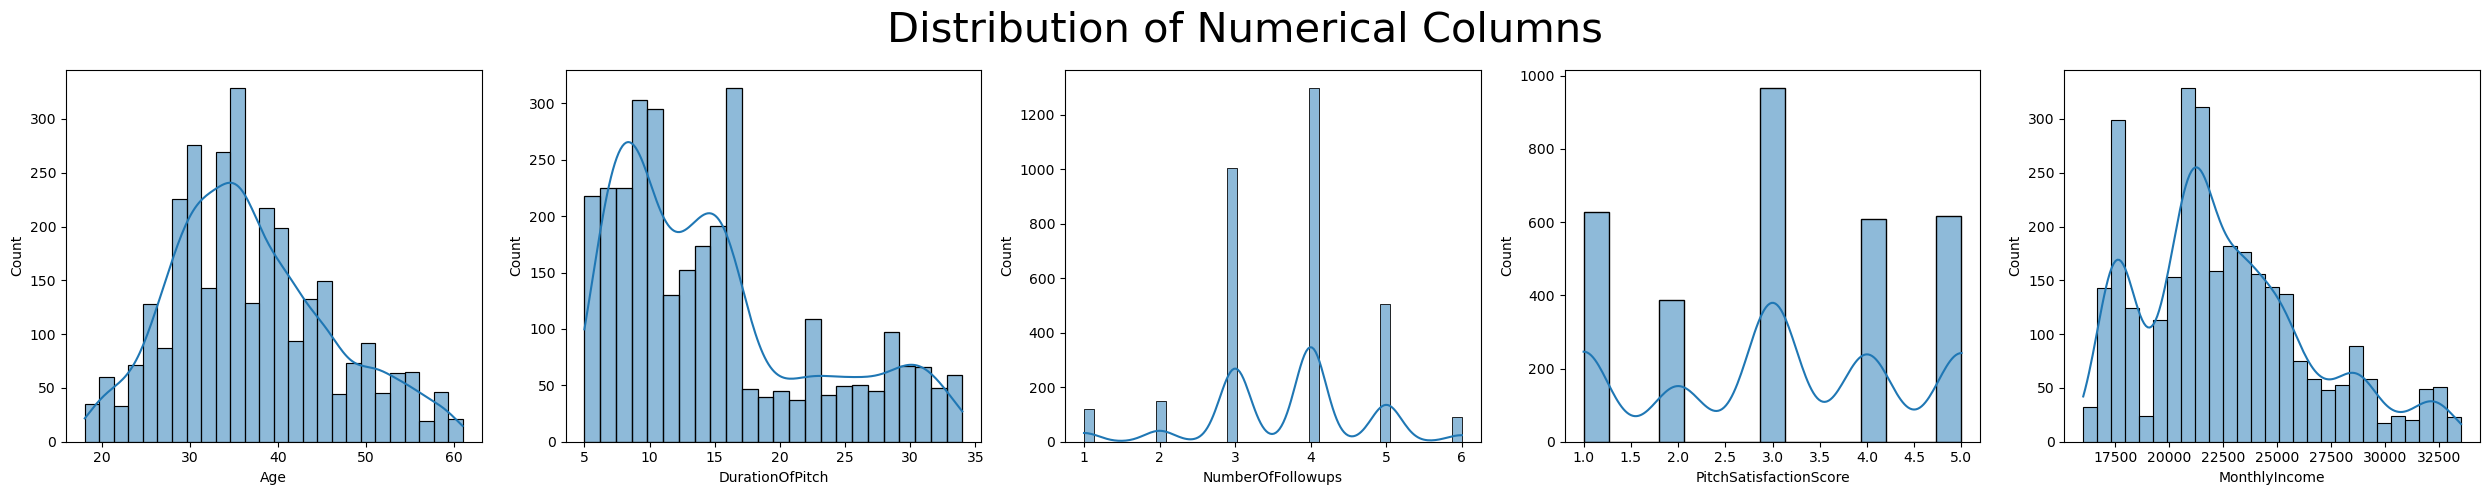

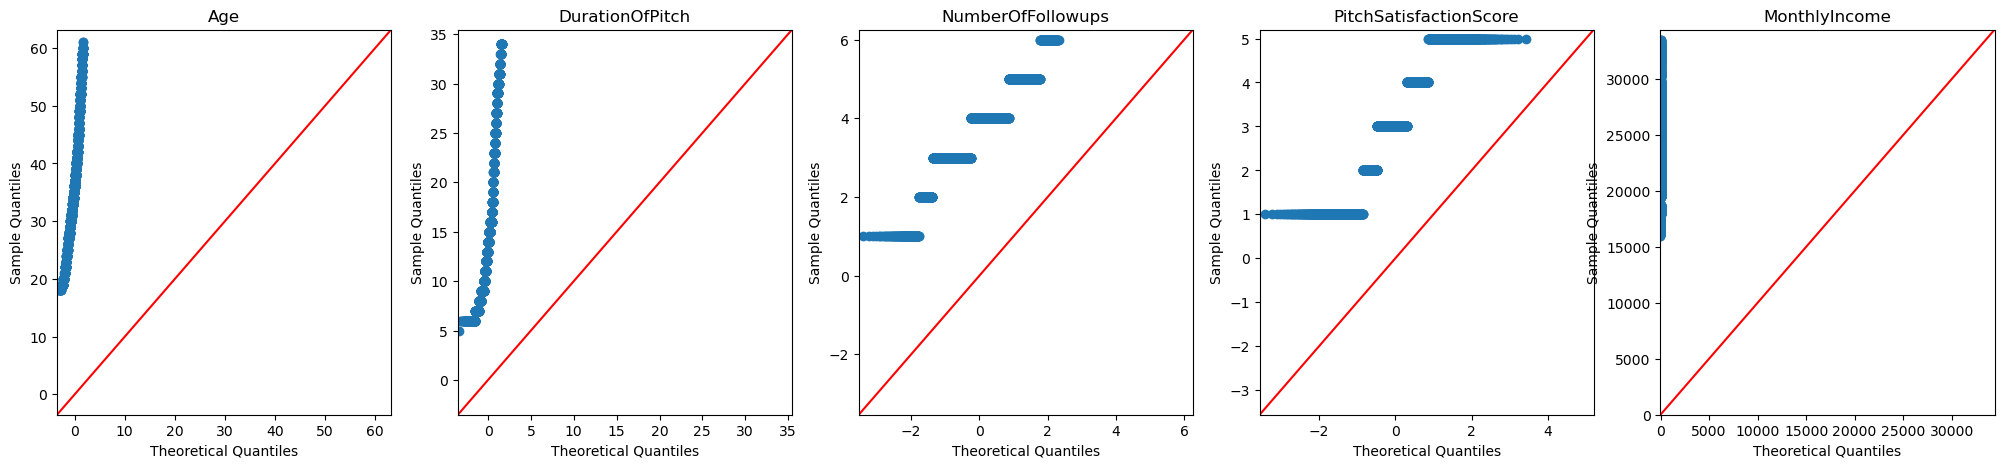

In [35]:
NormPlot(X_train[num_col])

In [36]:
X_train.describe().T

count          mean          std      min      25%  \
Age                     3047.0     36.887102     9.092238     18.0     30.0   
CityTier                3204.0      1.660112     0.918615      1.0      1.0   
DurationOfPitch         3027.0     14.952428     7.647971      5.0      9.0   
GenderMale              3204.0      0.596442     0.490687      0.0      0.0   
NumberOfFollowups       3173.0      3.691459     1.012367      1.0      3.0   
PreferredPropertyStar   3204.0      3.576467     0.795371      3.0      3.0   
HasPassport             3204.0      0.302122     0.459250      0.0      0.0   
PitchSatisfactionScore  3204.0      3.062734     1.363682      1.0      2.0   
MonthlyIncome           3047.0  22600.900558  3945.514261  16009.0  20015.5   

                            50%      75%      max  
Age                        36.0     42.0     61.0  
CityTier                    1.0      3.0      3.0  
DurationOfPitch            13.0     18.0     34.0  
GenderMale                  1.0      1.0      1.0  
NumberOfFollowups           4.0      4.0      6.0  
PreferredPropertyStar       3.0      4.0      5.0  
HasPassport                 0.0      1.0      1.0  
PitchSatisfactionScore      3.0      4.0      5.0  
MonthlyIncome           21839.0  24852.0  33530.0

**After Transforming**

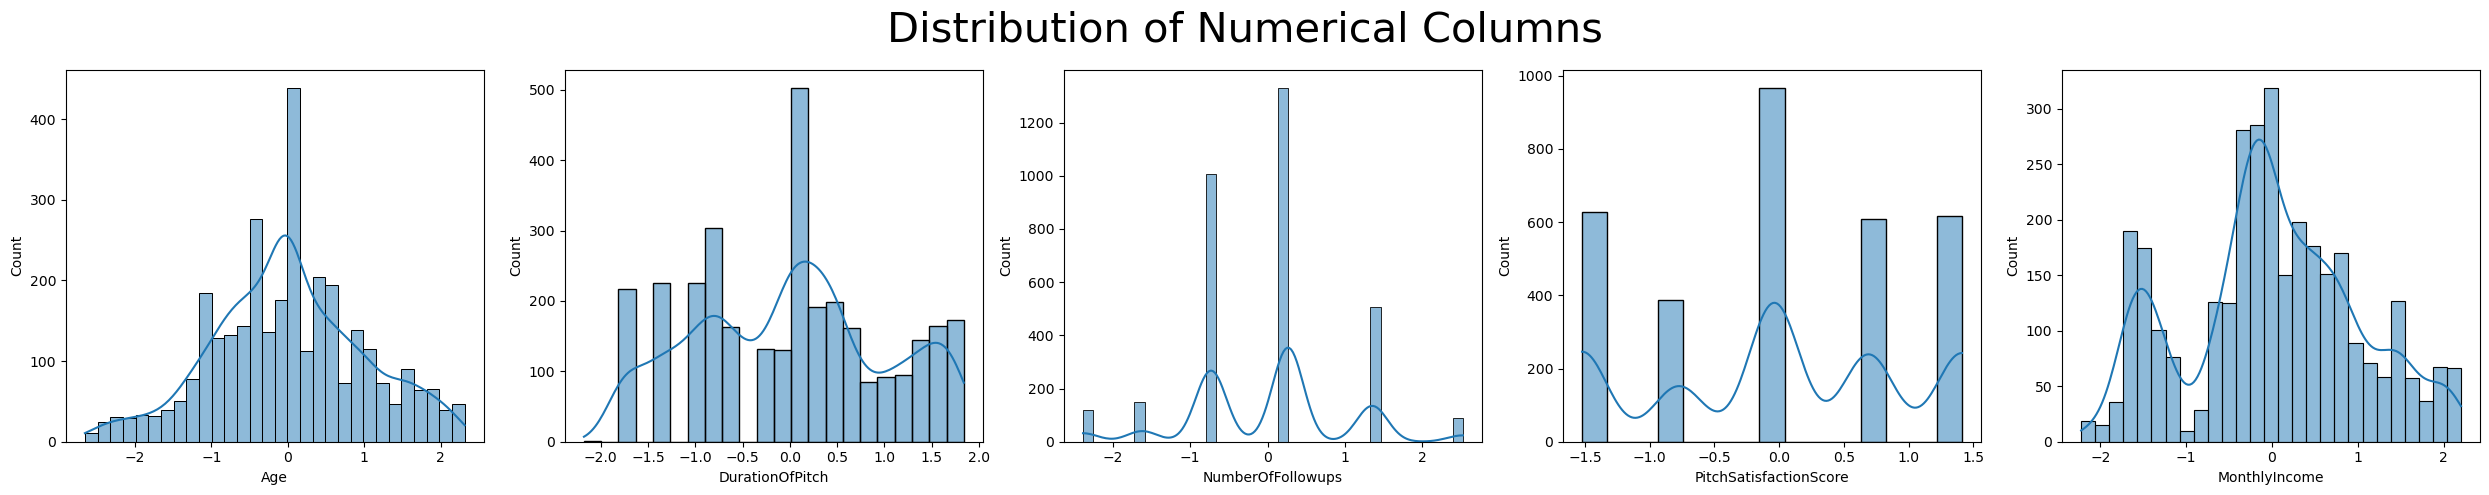

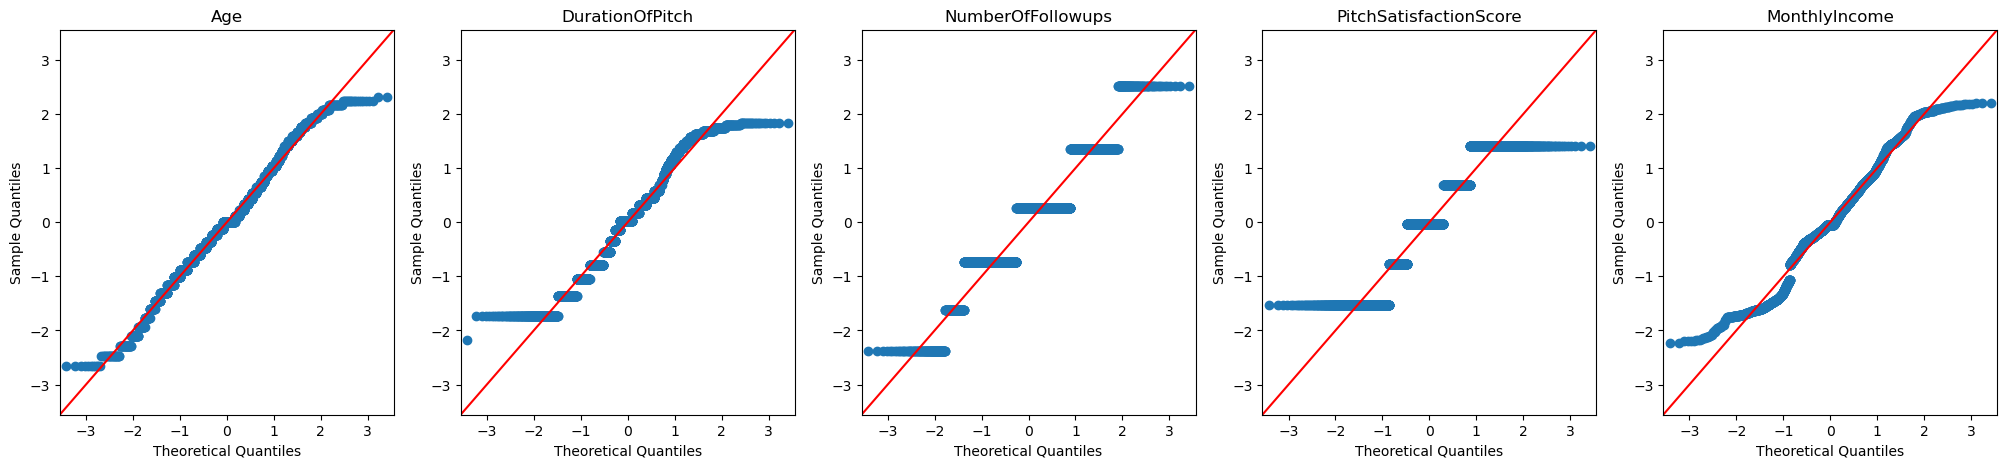

In [37]:
NormPlot(X_train_t1[num_col])

In [38]:
X_train_t1.describe().T

count          mean       std       min  \
Age                         3204.0 -8.892873e-16  1.000156 -2.655182   
DurationOfPitch             3204.0 -8.438249e-16  1.000156 -2.177690   
NumberOfFollowups           3204.0  1.685432e-16  1.000156 -2.384331   
PitchSatisfactionScore      3204.0 -3.265525e-16  1.000156 -1.522279   
MonthlyIncome               3204.0 -5.265535e-12  1.000156 -2.224303   
PreferredPropertyStar_3.0   3204.0  6.176654e-01  0.486034  0.000000   
PreferredPropertyStar_4.0   3204.0  1.882022e-01  0.390935  0.000000   
PreferredPropertyStar_5.0   3204.0  1.941323e-01  0.395593  0.000000   
CityTier_1                  3204.0  6.495006e-01  0.477201  0.000000   
CityTier_2                  3204.0  4.088639e-02  0.198058  0.000000   
CityTier_3                  3204.0  3.096130e-01  0.462406  0.000000   
Occupation_Others           3204.0  4.862672e-01  0.499889  0.000000   
Occupation_Small Business   3204.0  4.241573e-01  0.494292  0.000000   
Occupation_Large Business   3204.0  8.957553e-02  0.285617  0.000000   
MaritalStatus_Unmarried     3204.0  3.333333e-01  0.471478  0.000000   
MaritalStatus_Married       3204.0  4.744070e-01  0.499423  0.000000   
MaritalStatus_Divorced      3204.0  1.922597e-01  0.394138  0.000000   
Designation_Executive       3204.0  4.029338e-01  0.490564  0.000000   
Designation_Manager         3204.0  3.789014e-01  0.485189  0.000000   
Designation_Senior Manager  3204.0  1.604245e-01  0.367057  0.000000   
Designation_AVP             3204.0  5.461923e-02  0.227271  0.000000   
Designation_VP              3204.0  3.121099e-03  0.055788  0.000000   
GenderMale                  3204.0  5.964419e-01  0.490687  0.000000   
HasPassport                 3204.0  3.021223e-01  0.459250  0.000000   

                                 25%       50%       75%       max  
Age                        -0.612360 -0.003419  0.646325  2.314852  
DurationOfPitch            -0.787611  0.017821  0.568314  1.838899  
NumberOfFollowups          -0.730372  0.264090  0.264090  2.522898  
PitchSatisfactionScore     -0.774197 -0.037736  0.690203  1.411421  
MonthlyIncome              -0.544809 -0.050011  0.669946  2.203831  
PreferredPropertyStar_3.0   0.000000  1.000000  1.000000  1.000000  
PreferredPropertyStar_4.0   0.000000  0.000000  0.000000  1.000000  
PreferredPropertyStar_5.0   0.000000  0.000000  0.000000  1.000000  
CityTier_1                  0.000000  1.000000  1.000000  1.000000  
CityTier_2                  0.000000  0.000000  0.000000  1.000000  
CityTier_3                  0.000000  0.000000  1.000000  1.000000  
Occupation_Others           0.000000  0.000000  1.000000  1.000000  
Occupation_Small Business   0.000000  0.000000  1.000000  1.000000  
Occupation_Large Business   0.000000  0.000000  0.000000  1.000000  
MaritalStatus_Unmarried     0.000000  0.000000  1.000000  1.000000  
MaritalStatus_Married       0.000000  0.000000  1.000000  1.000000  
MaritalStatus_Divorced      0.000000  0.000000  0.000000  1.000000  
Designation_Executive       0.000000  0.000000  1.000000  1.000000  
Designation_Manager         0.000000  0.000000  1.000000  1.000000  
Designation_Senior Manager  0.000000  0.000000  0.000000  1.000000  
Designation_AVP             0.000000  0.000000  0.000000  1.000000  
Designation_VP              0.000000  0.000000  0.000000  1.000000  
GenderMale                  0.000000  1.000000  1.000000  1.000000  
HasPassport                 0.000000  0.000000  1.000000  1.000000

## 3.5. Select Model and Evaluation Strategy

### 3.5.1 Load Selected Model
Model that might Suit for this task are:
1. Logistic Regression (Baseline)
2. Support Vector Machine Classifier
3. Random Forest Classifier
4. XGBoost Classifier
5. Neural Networks

In [39]:
#import Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

### 3.5.2. Select Metric of Evaluation

In [40]:
from sklearn.metrics \
import (
    #scorer matrix
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    average_precision_score,
    roc_auc_score,

    #curve
    precision_recall_curve,
    roc_curve,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,

    #reporting
    classification_report
)

#create core
auc_roc = make_scorer(roc_auc_score)
avg_precision = make_scorer(average_precision_score)
f1 = make_scorer(f1_score)
precision = make_scorer(precision_score)
recall = make_scorer(recall_score)
accuracy = make_scorer(accuracy_score)

### 3.5.3. Create Function to Evaluate Model Performance

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_binary_classification(model, 
                                   X_train=X_train,
                                   X_test=X_test,
                                   y_train=y_train, 
                                   y_test=y_test):
    """
    Evaluate binary classification performance on both training and testing data.
    
    Parameters:
    y_train (array-like): True binary labels for training data.
    y_test (array-like): True binary labels for testing data.
    y_pred_train (array-like): Predicted probabilities or scores for training data.
    y_pred_test (array-like): Predicted probabilities or scores for testing data.
    
    Returns:
    None: Displays the plots and metrics tables.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    def calculate_metrics(y_true, y_pred):
        y_pred_labels = (y_pred >= 0.5).astype(int)
        roc_auc_val = roc_auc_score(y_true, y_pred)
        avg_precision_val = average_precision_score(y_true, y_pred)
        accuracy_val = accuracy_score(y_true, y_pred_labels)
        precision_val = precision_score(y_true, y_pred_labels)
        recall_val = recall_score(y_true, y_pred_labels)
        f1_val = f1_score(y_true, y_pred_labels)
        return {
            "roc_auc": roc_auc_val,
            "avg_precision" : avg_precision_val,
            "accuracy": accuracy_val,
            "precision": precision_val,
            "recall": recall_val,
            "f1": f1_val,
            "confusion_matrix": confusion_matrix(y_true, y_pred_labels)
        }
    
    # Calculate metrics for training and testing data
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # ROC AUC Curve (Training vs Testing) using RocCurveDisplay
    RocCurveDisplay.from_estimator(model, X_train, y_train, ax=axes[0, 0], name='Train ROC')
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0, 0], name='Test ROC', color='green')
    axes[0, 0].set_title('Receiver Operating Characteristic (ROC)')

    # Precision-Recall Curve (Training vs Testing) using PrecisionRecallDisplay
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[0, 1], name='Train PR')
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[0, 1], name='Test PR', color='green')
    axes[0, 1].set_title('Precision-Recall Curve')

    # Confusion Matrix (Testing Data) using ConfusionMatrixDisplay
    ConfusionMatrixDisplay(test_metrics["confusion_matrix"]).plot(ax=axes[1, 0], cmap='Blues')
    axes[1, 0].set_title('Confusion Matrix (Test Data)')

    # Metrics Table (Training and Testing Data)
    metrics_table = [
        ['Metric', 'Train', 'Test'],
        ['AUC (ROC)', f'{train_metrics["roc_auc"]:.2f}', f'{test_metrics["roc_auc"]:.2f}'],
        ['Avg Precision', f'{train_metrics["avg_precision"]:.2f}', f'{test_metrics["avg_precision"]:.2f}'],
        ['Precision', f'{train_metrics["precision"]:.2f}', f'{test_metrics["precision"]:.2f}'],
        ['Recall', f'{train_metrics["recall"]:.2f}', f'{test_metrics["recall"]:.2f}'],
        ['F1 Score', f'{train_metrics["f1"]:.2f}', f'{test_metrics["f1"]:.2f}'],
        ['Accuracy', f'{train_metrics["accuracy"]:.2f}', f'{test_metrics["accuracy"]:.2f}']
    ]
    
    axes[1, 1].axis('off')
    table = axes[1, 1].table(cellText=metrics_table, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    axes[1, 1].set_title('Classification Metrics', fontsize=14)
    
    plt.tight_layout()
    plt.show()

### 3.6.4. Refit Strategy

In [42]:
#scoring = [roc_auc_score, average_precision_score, precision_score, recall_score, f1_score]
scoring = ['roc_auc', 'average_precision', 'precision', 'recall', 'f1', 'accuracy']
refit_strategy = 'average_precision'

### 3.6.5. Cross Validation

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(5,
                                  random_state=seed)

### 3.6.6 Create Plain Pipeline For Model

In [44]:
plain_weight_based_preprocess_pipe = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder_ohe),
    ('transcaler', transcaler)
])

plain_info_based_preprocess_pipe = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder_lb)
])

# 4. Find The Best Candidate Model

## 4.1 Train and Evaluate Models using Plain Models

### 4.1.1 Logistic Regression

In [45]:
logit_md = LogisticRegression(random_state=seed)
plain_lg = OuterPipeline([
    ('preprocessor', plain_weight_based_preprocess_pipe),
    ('model', logit_md)
])

plain_lg

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4520>),
                                 ('transcaler',
                                  <__main__.TranScaler object at 0x0000023DD91E8F70>)])),
                ('model', LogisticRegression(random_state=6))])

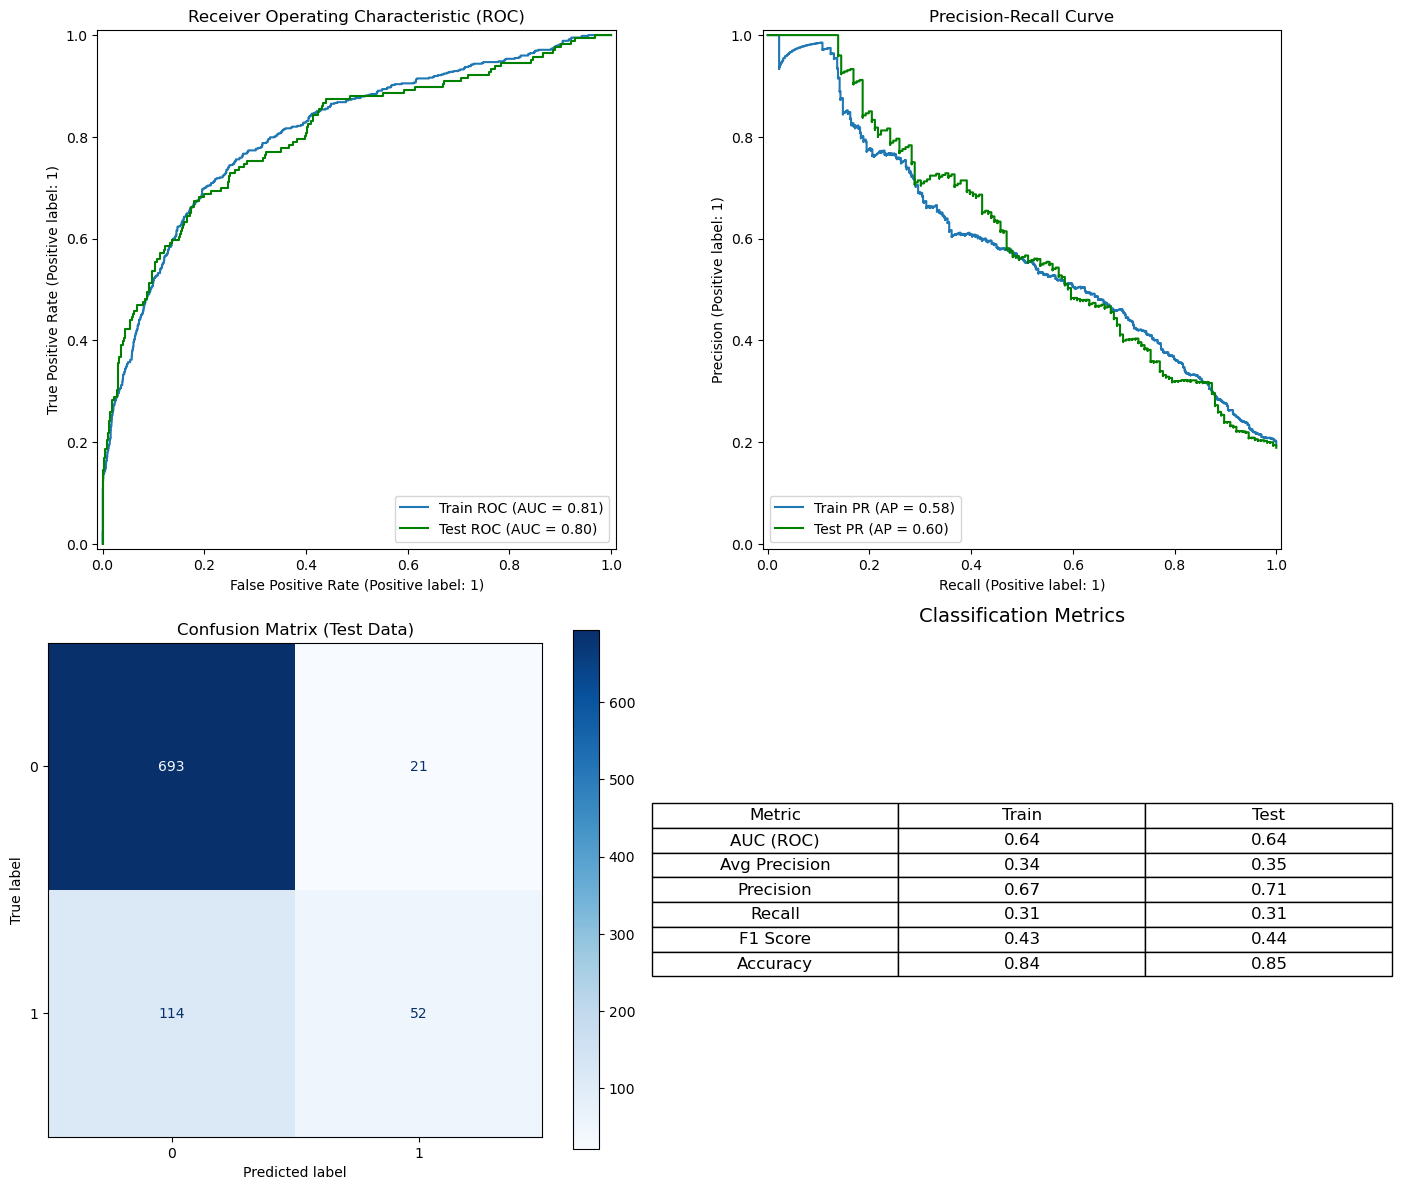

In [46]:
plain_lg.fit(X_train, y_train)

evaluate_binary_classification(plain_lg)

### 4.1.2 Naive Bayes

In [47]:
nb_md = GaussianNB()
plain_nb = OuterPipeline([
    ('preprocessor', plain_weight_based_preprocess_pipe),
    ('model', nb_md)
])

plain_nb

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4520>),
                                 ('transcaler',
                                  <__main__.TranScaler object at 0x0000023DD91E8F70>)])),
                ('model', GaussianNB())])

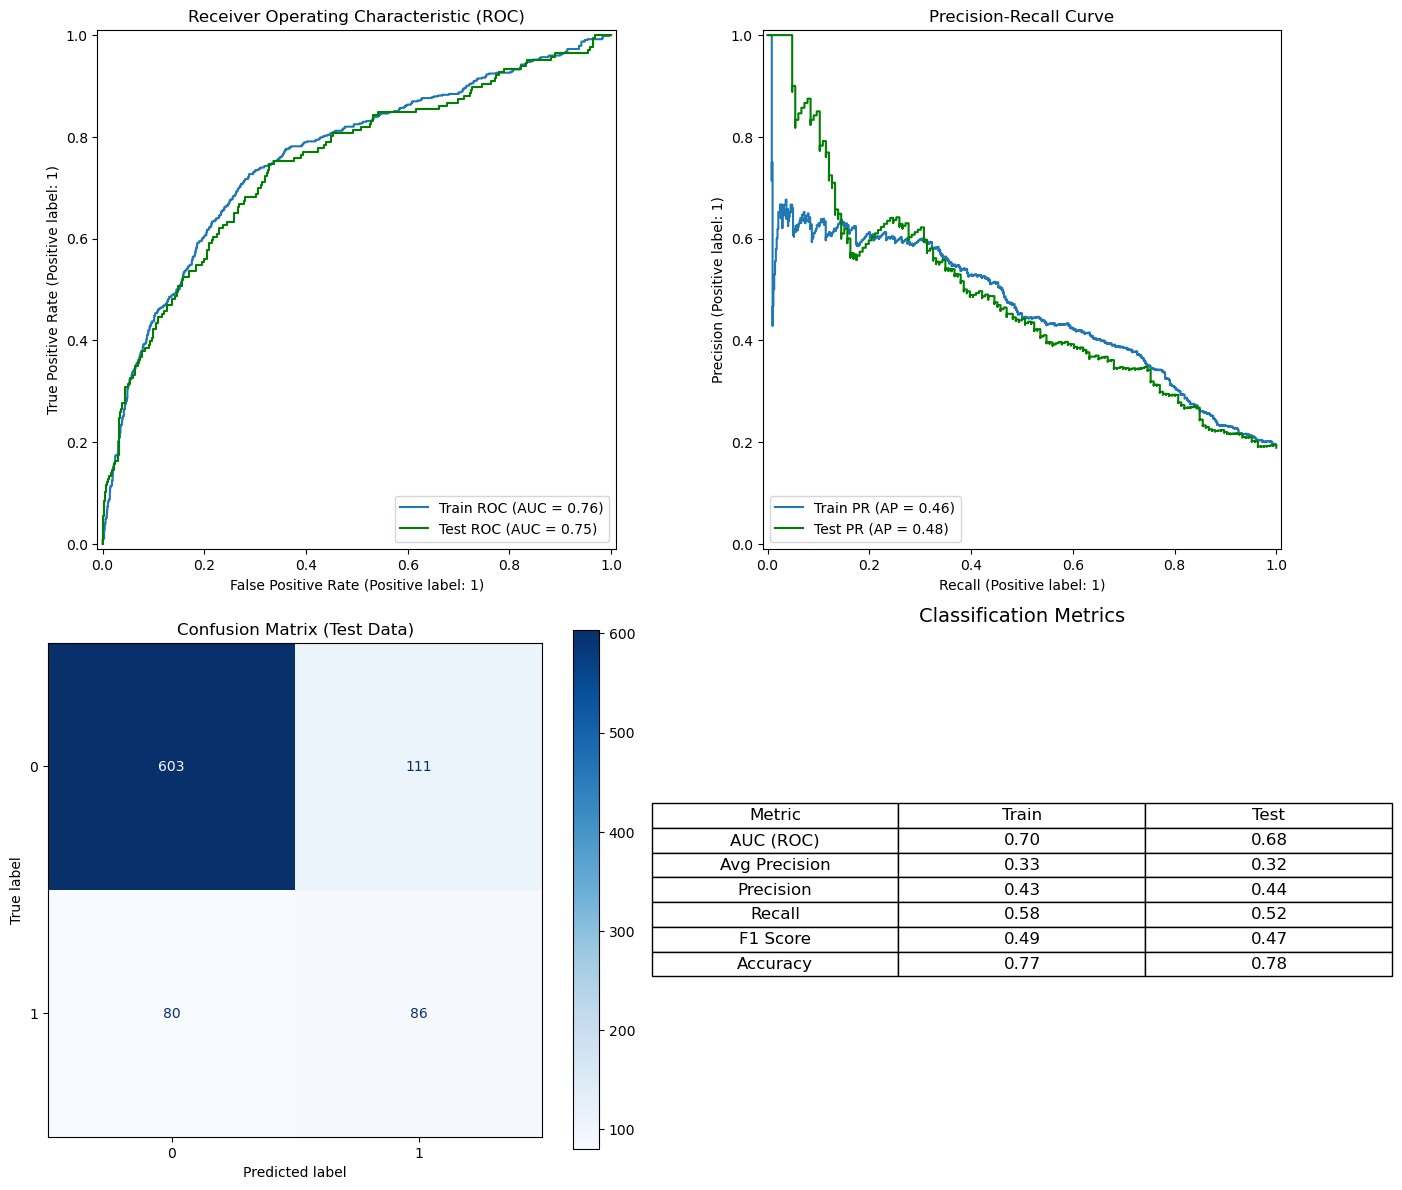

In [48]:
plain_nb.fit(X_train, y_train)

evaluate_binary_classification(plain_nb)

### 4.1.3 Support Vector Machine

In [49]:
svc_md = SVC(random_state=seed)
plain_svc = OuterPipeline([
    ('preprocessor', plain_weight_based_preprocess_pipe),
    ('model', svc_md)
])

plain_svc

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4520>),
                                 ('transcaler',
                                  <__main__.TranScaler object at 0x0000023DD91E8F70>)])),
                ('model', SVC(random_state=6))])

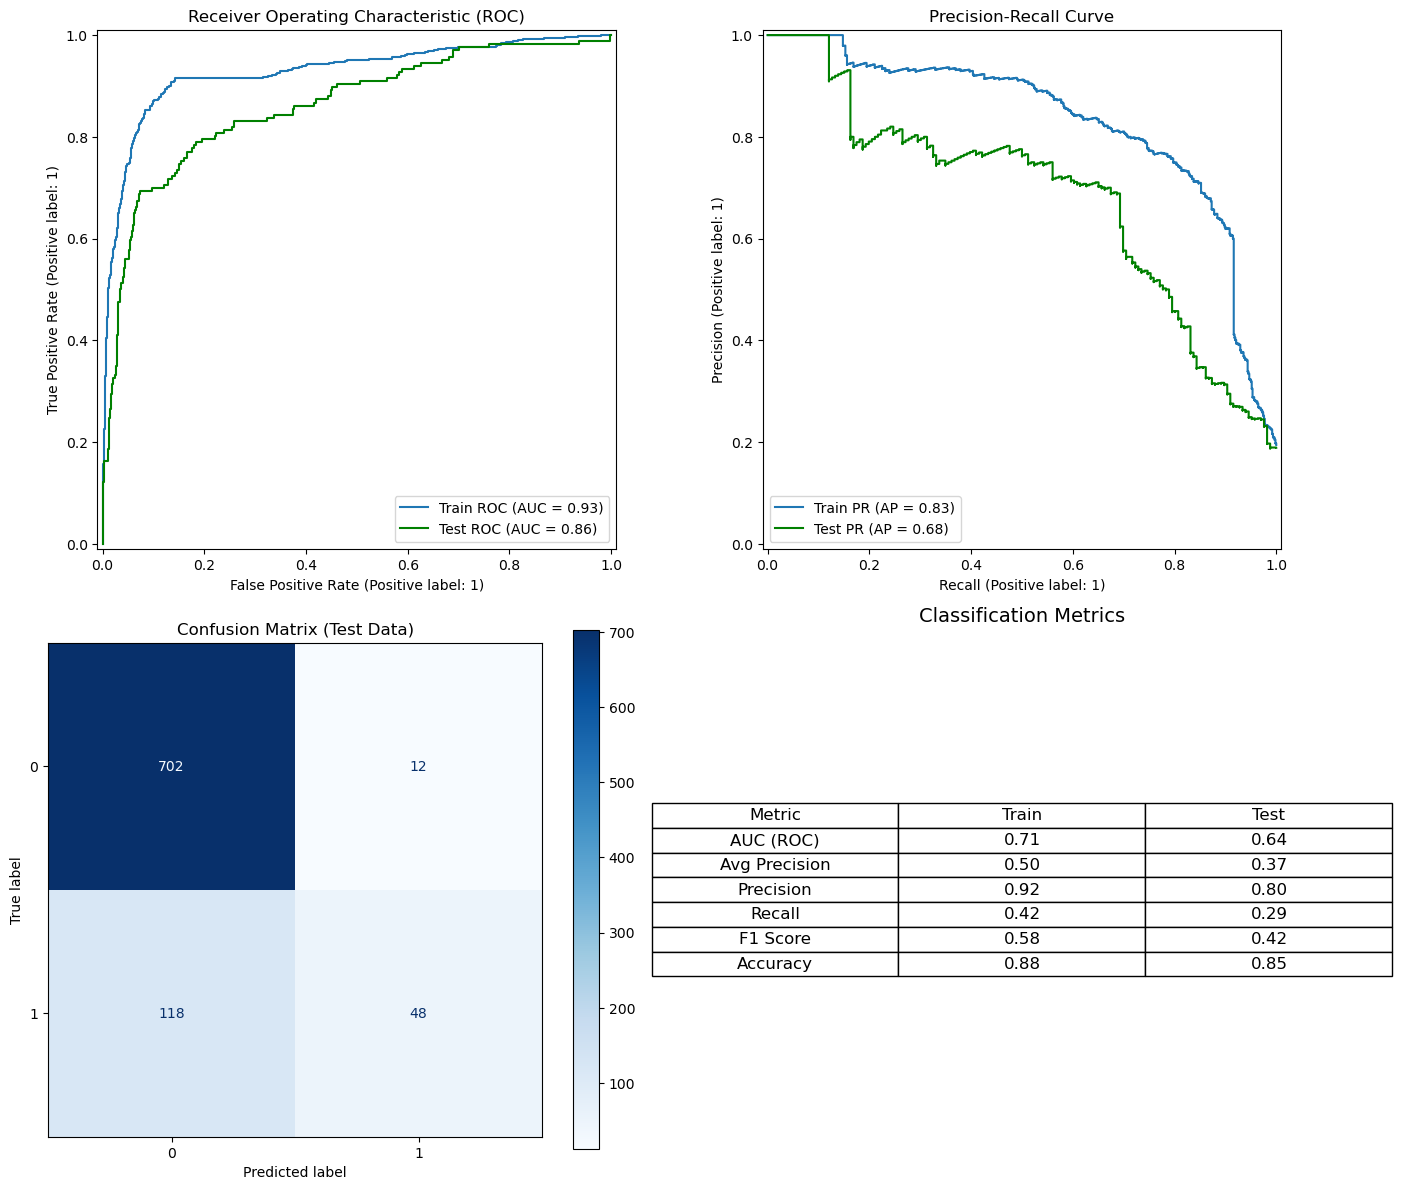

In [50]:
plain_svc.fit(X_train, y_train)

evaluate_binary_classification(plain_svc)

### 4.1.4 Decision Tree

In [51]:
dt_md =  DecisionTreeClassifier(random_state=seed)
plain_dt = OuterPipeline([
    ('preprocessor', plain_info_based_preprocess_pipe),
    ('model', dt_md)
])

plain_dt

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4C40>)])),
                ('model', DecisionTreeClassifier(random_state=6))])

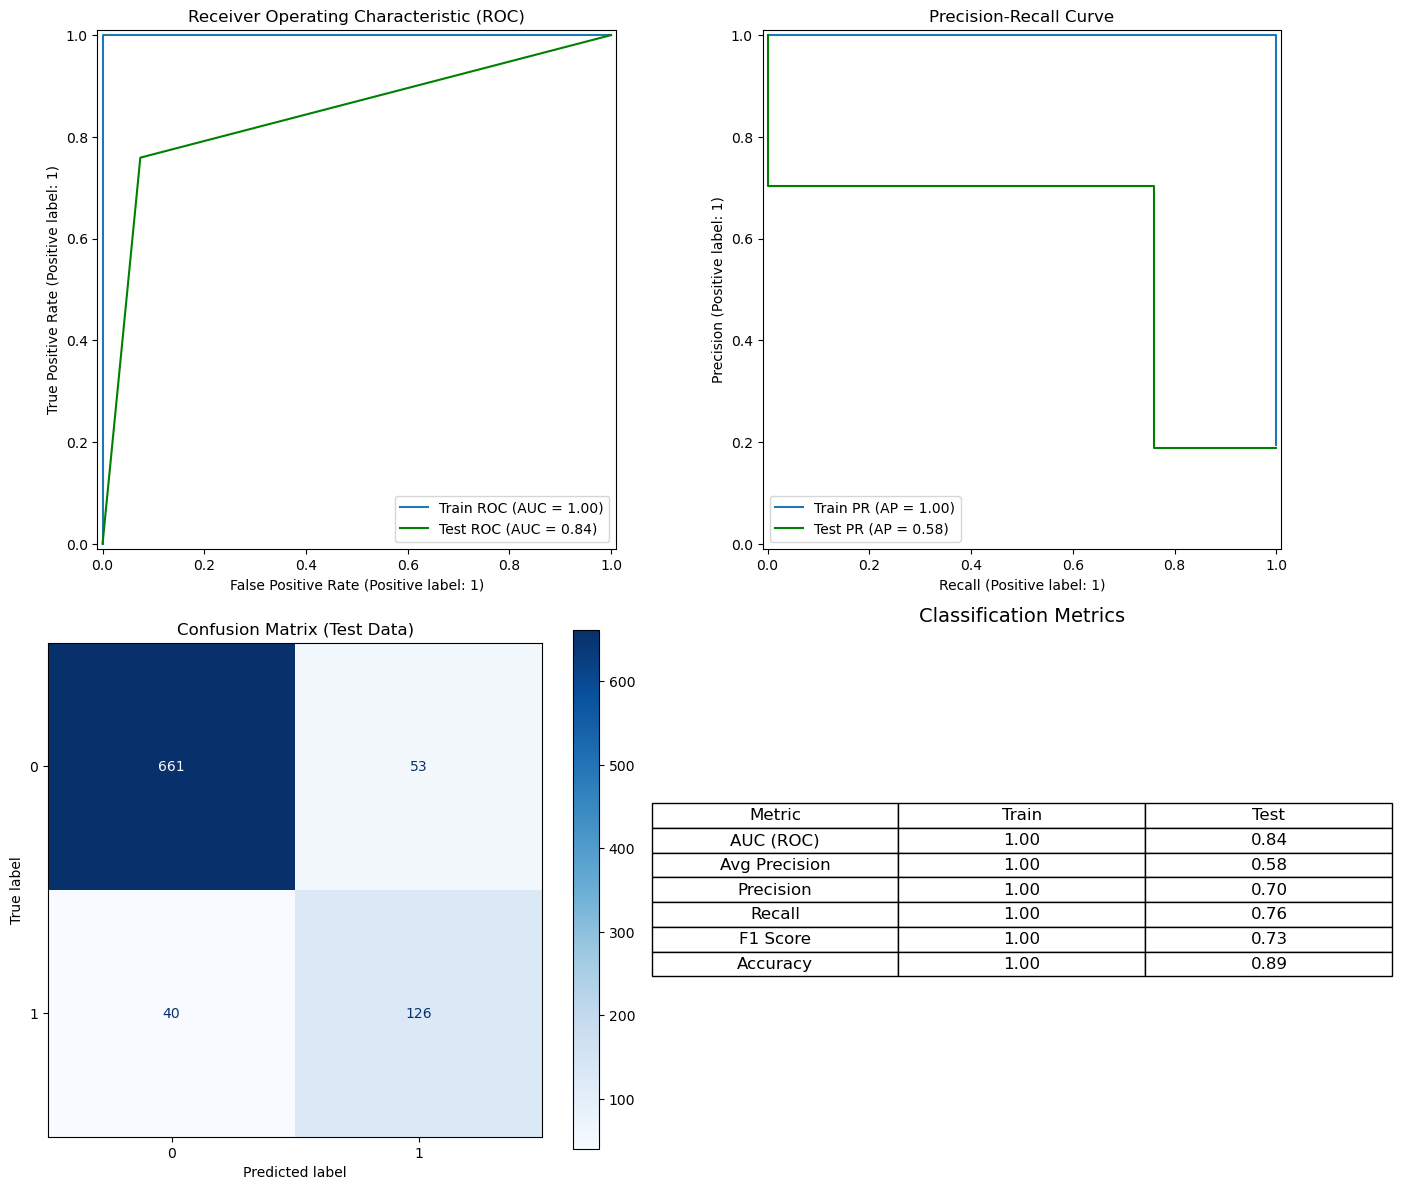

In [52]:
plain_dt.fit(X_train, y_train)

evaluate_binary_classification(plain_dt)

### 4.1.5 Random Forest

In [53]:
rf_md = RandomForestClassifier(random_state=seed)
plain_rf = OuterPipeline([
    ('preprocessor', plain_info_based_preprocess_pipe),
    ('model', rf_md)
])

plain_rf

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4C40>)])),
                ('model', RandomForestClassifier(random_state=6))])

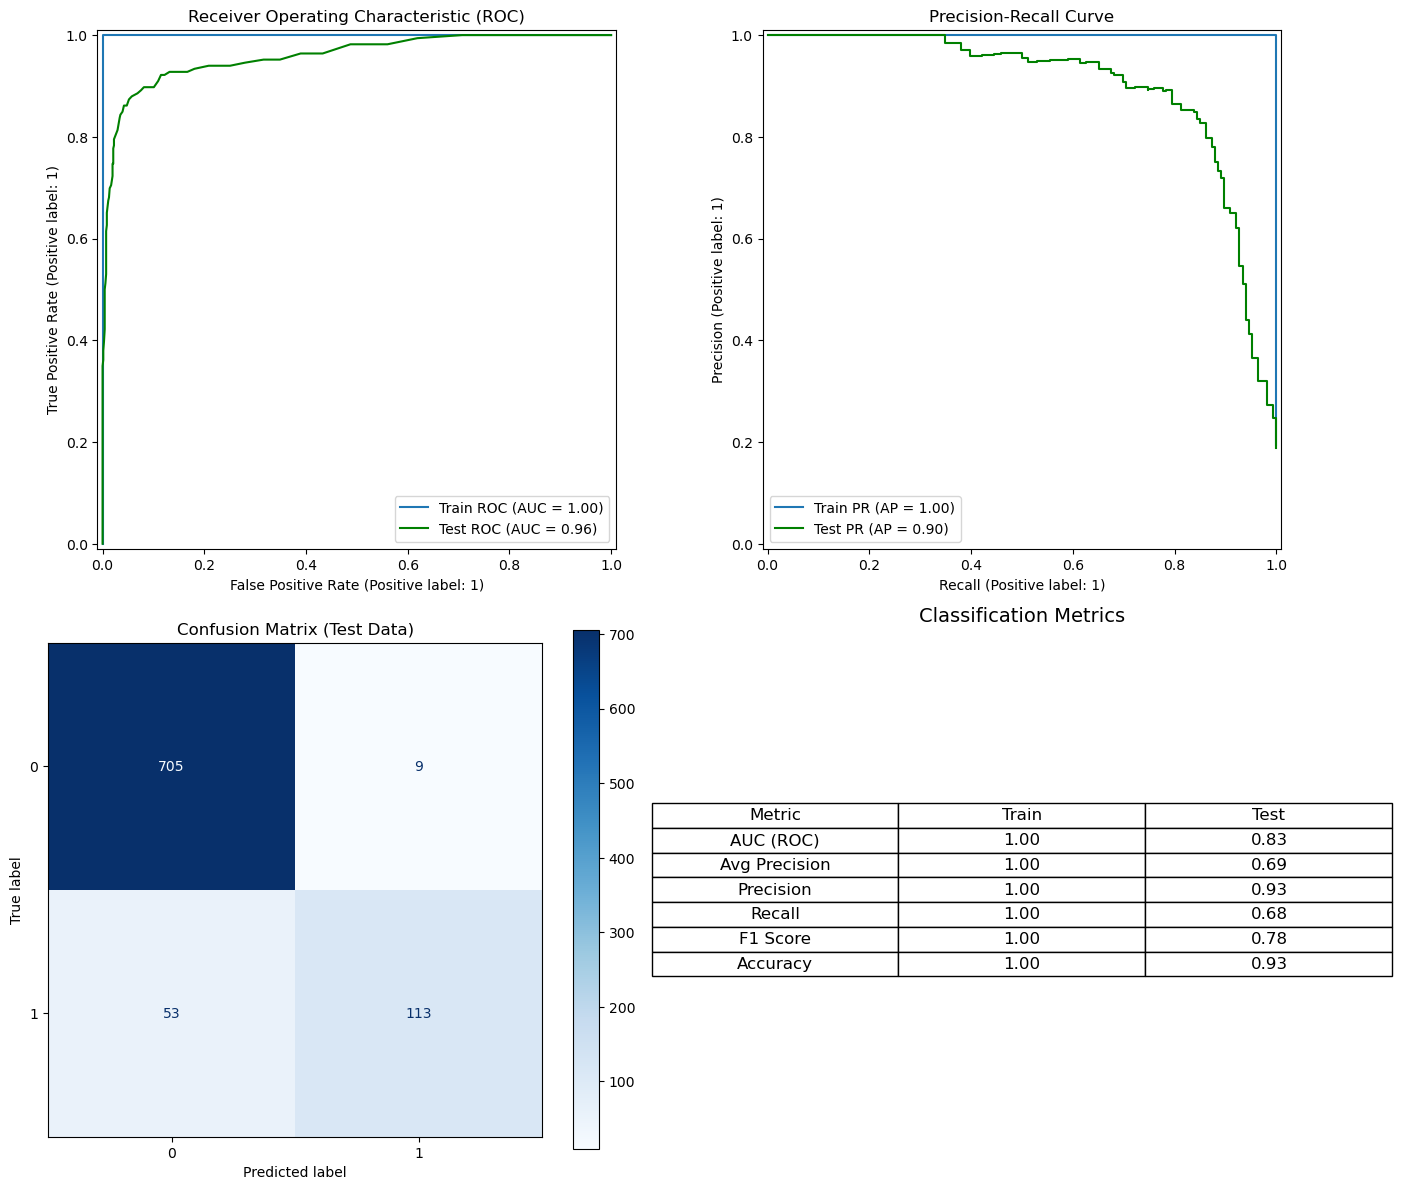

In [54]:
plain_rf.fit(X_train, y_train)

evaluate_binary_classification(plain_rf)

### 4.1.6 AdaBoost

In [55]:
ada_md = AdaBoostClassifier(random_state=seed)
plain_ada = OuterPipeline([
    ('preprocessor', plain_info_based_preprocess_pipe),
    ('model', ada_md)
])

plain_ada

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4C40>)])),
                ('model', AdaBoostClassifier(random_state=6))])

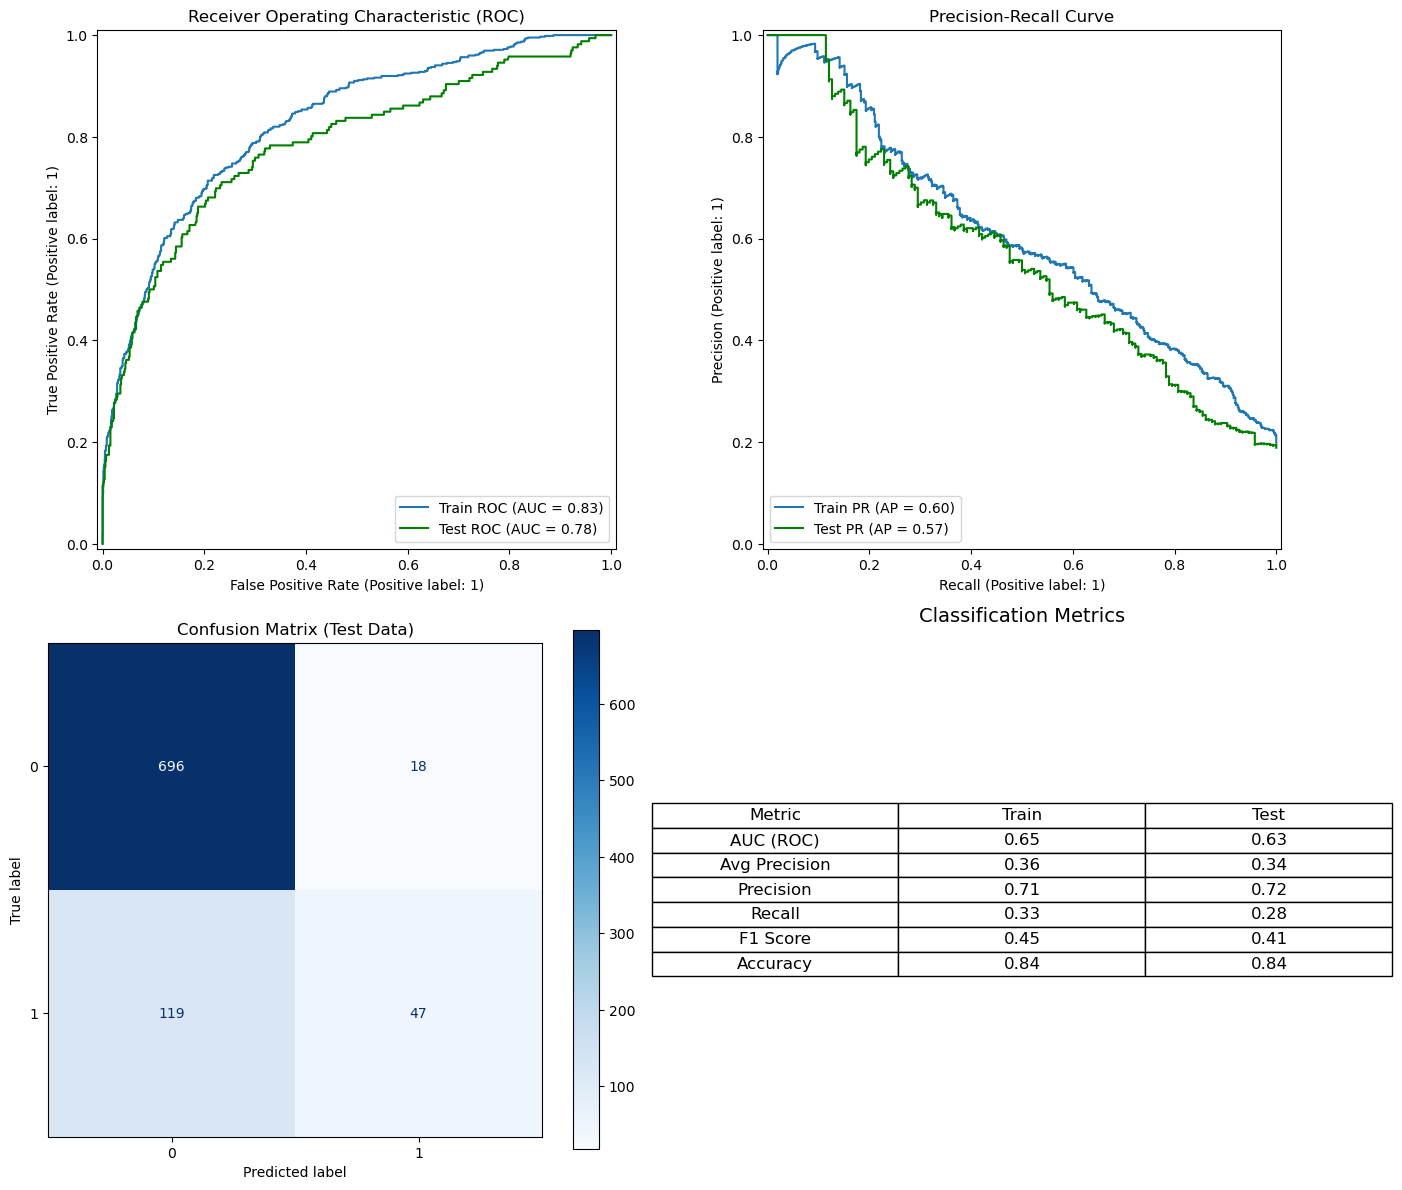

In [56]:
plain_ada.fit(X_train, y_train)

evaluate_binary_classification(plain_ada)

### 4.1.7 CatBoost

In [57]:
cat_md = CatBoostClassifier(random_state=seed, verbose=False)
plain_cat = OuterPipeline([
    ('preprocessor', plain_info_based_preprocess_pipe),
    ('model', cat_md)
])

plain_cat

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4C40>)])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000023DDBBD4100>)])

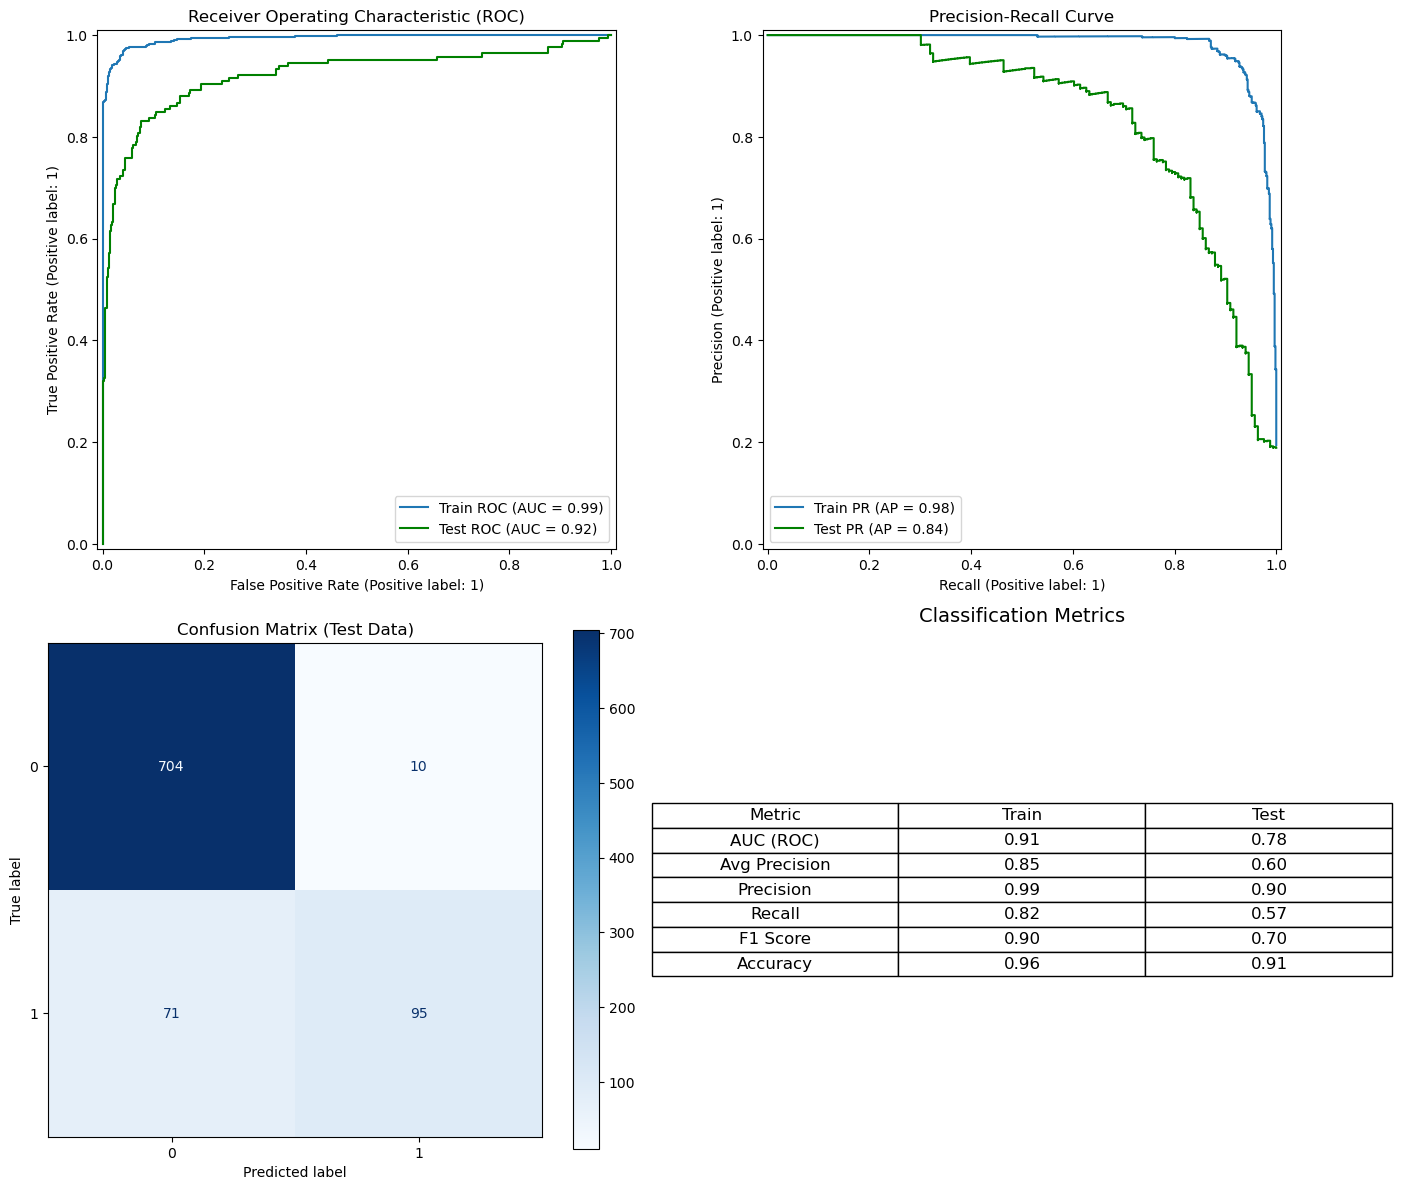

In [58]:
plain_cat.fit(X_train, y_train)

evaluate_binary_classification(plain_cat)

### 4.1.8 XGBoost

In [59]:
xgb_md = XGBClassifier(random_state=seed, verbose=False)
plain_xgb = OuterPipeline([
    ('preprocessor', plain_info_based_preprocess_pipe),
    ('model', xgb_md)
])

plain_xgb

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnImputer(steps=[('median_imputer',
                                                        SimpleImputer(strategy='median'),
                                                        ['Age',
                                                         'DurationOfPitch',
                                                         'NumberOfFollowups',
                                                         'PreferredPropertyStar',
                                                         'MonthlyIncome'])])),
                                 ('encoder',
                                  <__main__.ICode object at 0x0000023DD91F4C40>)])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=6, ...))])

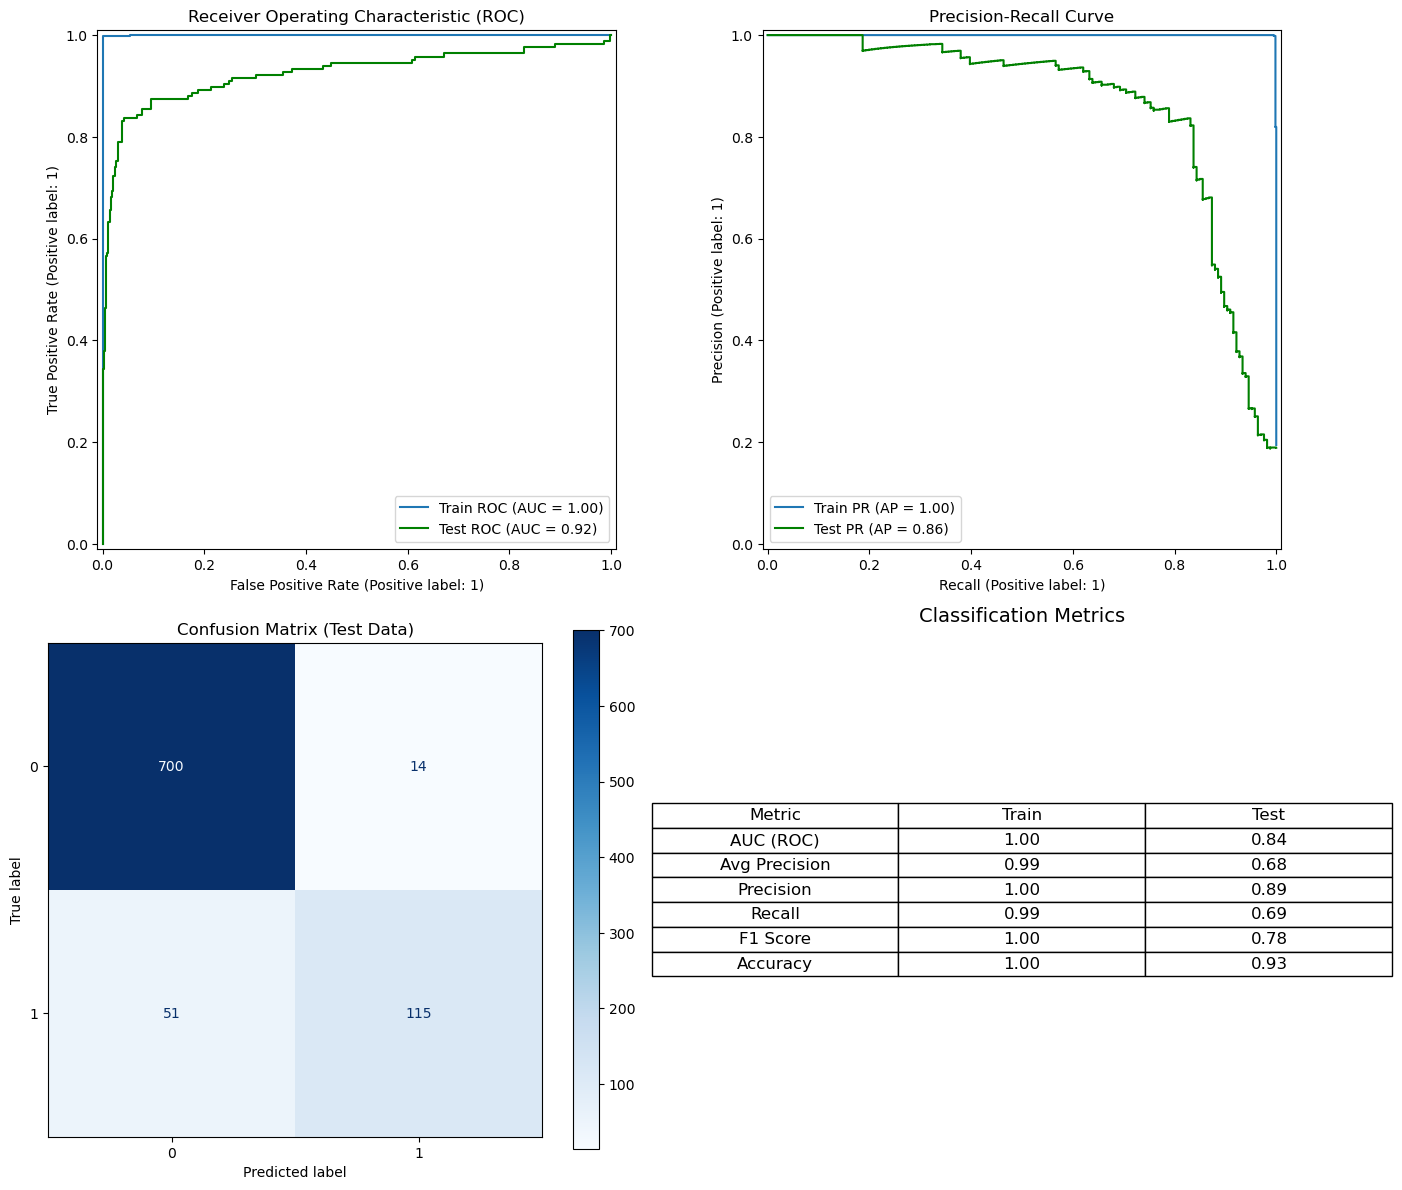

In [60]:
plain_xgb.fit(X_train, y_train)

evaluate_binary_classification(plain_xgb)

## 4.2 Compare Model Performances

In [61]:
from sklearn.model_selection import train_test_split

def variable_to_str(var):
    for key, value in globals().items():
        if value is var:
            return key
    return None


def stratified_batches(df, 
                       stratify_cols=['CompanyInvited', 'ProdTaken'], 
                       n_batches=5, 
                       returned_index_only=True,
                       random_state=seed):
    """
    Splits the DataFrame into n stratified batches.

    Parameters:
    df (pd.DataFrame): The dataset to be split.
    stratify_cols (list): The columns to use for stratification.
    n_batches (int): The number of batches to create.

    Returns:
    list of pd.DataFrame: A list containing n stratified batches of the dataset.
    """
    if n_batches < 2:
        raise ValueError("n_batches must be 2 or more")

    # Create a stratification key by combining the stratify columns
    df['stratify_key'] = df[stratify_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    # Split the data into n stratified batches
    batches = []
    current_df = df.copy()
    
    for i in range(n_batches - 1):
        batch, current_df = train_test_split(
            current_df,
            test_size=int(len(current_df) * (n_batches - i - 1) / n_batches),
            stratify=current_df['stratify_key'],
            random_state=random_state
        )
        batches.append(batch)
    batches.append(current_df)  # The last batch

    if returned_index_only:
        index_batches = []       
        for batch in batches:
            index_batch = batch.index
            index_batches.append(index_batch)

        return index_batches
    else:
        for batch in batches:
            cols_to_drop = stratify_cols.append('stratify_key')
            batch.drop(columns=cols_to_drop, inplace=True)  # Clean up the added column
        return batches


def compare_model_scores(*models,
                         scorers:'list',
                         dataset = test_df,
                         n_batches = 5,
                         random_state=seed):
    
    # split dataset for testing
    batches_index = stratified_batches(dataset,                        
                                       random_state=random_state)

    results = {
        'model' : [],
        'scorer' : [],
        'split' : [],
        'score' : []
    }
    # loop over all models
    for model in models:  
        # calculate scores on each dataset
        for scorer in scorers:
            for i, batch_index in enumerate(batches_index):
                X = X_test.iloc[batch_index, :]
                y = y_test.iloc[batch_index]
                score = scorer(model, X, y)
                
                # add model name
                results['model'].append(variable_to_str(model))
                # add scorer name
                results['scorer'].append(scorer.__dict__['_score_func'].__name__)
                # add split
                results['split'].append(i+1)
                # add score
                results['score'].append(score)            

    # create dataframe
    results = pd.DataFrame(results)

    return results

In [62]:
def plot_model_scores_comparisons(*models,
                                  scorers:'list',
                                  dataset = test_df,
                                  n_batches = 5,
                                  return_comparations_table = False,
                                  random_state=seed):

    comp_results = compare_model_scores(*models, 
                                        scorers = scorers, 
                                        dataset = dataset, 
                                        n_batches = n_batches)

    plt.figure(figsize=(12, 8))
    
    sns.barplot(
        comp_results,
        x = 'scorer',
        y = 'score',
        hue = 'model'
    )
    
    plt.title("Model Score Comparison On Testing Dataset", size=20)
    plt.legend(
        loc = 'center left',
        bbox_to_anchor = [1.05, 0.5]
    )
    
    plt.plot();

    if return_comparations_table: return comp_results

def compare_model_table(c):
    cg = c.groupby(by=['model', 'scorer']).agg({'score' : [np.mean, np.std]})
    cg.reset_index(inplace=True)
    cg.columns = ['model', 'scorer', 'mean score', 'std score']
    return 100*cg.pivot(index='scorer', columns = 'model').round(4)

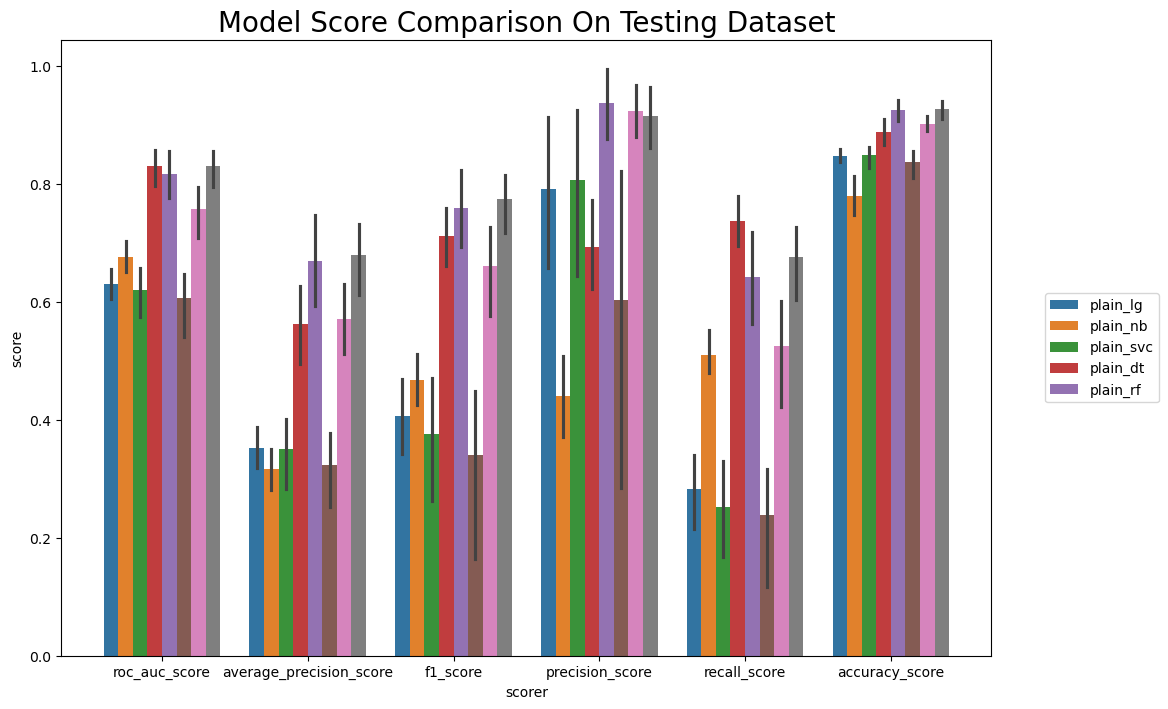

In [63]:
scorers = [auc_roc, avg_precision, f1, precision, recall, accuracy]

c = plot_model_scores_comparisons(
    plain_lg, plain_nb, plain_svc, plain_dt, plain_rf, plain_ada, plain_cat, plain_xgb, 
    scorers = scorers, return_comparations_table = True
)

## 4.3 Choose 3 Best Candidate Models

from above performances, we choose 3 models for further enhancement includings:
1. Random Forest
2. CatBoost
3. XGBoost

# 5. Improve Model Performances

In [64]:
def plot_grid_params_towards_score(model, suptitle = "", scoring = scoring, class_weights_param = False):
    # get all scoring string
    scoring = ['mean_test_'+score for score in scoring]

    # get all parameters from model grid
    grid_params = ['param_'+grid_param for grid_param in model.param_grid.keys()]

    # get grid cross validation results
    grid_cv = pd.DataFrame(model.cv_results_)

    # restructured the dataframe
    grid_cv = pd.melt(grid_cv, 
                      id_vars = grid_params,
                      value_vars = scoring)

    if class_weights_param:
        grid_cv['param_model__class_weight'] = grid_cv['param_model__class_weight'].apply(lambda x: x[1])
        grid_cv[grid_cv['param_model__class_weight'] == 'a']['param_model__class_weight'] = 'balanced'
    
    # plot results
    for score in scoring:
        fig, ax = plt.subplots(1, len(grid_params), 
                               figsize=(6*len(grid_params), 4), sharey=True)
        ax = ax.flatten()
        for ax_id, param in enumerate(grid_params):
            sns.barplot(grid_cv,
                        x = param, y='value', ax = ax[ax_id])
            ax[ax_id].set_title(f"{param}")
            ax[ax_id].set_ylabel(f"{score}")
        plt.suptitle(suptitle, size=24)
        plt.tight_layout()
        plt.plot();

## 5.1 Random Forest

### 5.1.1 Create Pipeline Comparison

In [71]:
ovrsamp_rf_md = RandomForestClassifier(random_state=seed)
ovrsamp_rf = Pipeline([
    ('imputer', imputer),
    ('class_balancer', ros),
    ('encoder', encoder_lb),
    ('model', ovrsamp_rf_md)
])

synsamp_rf_md = RandomForestClassifier(random_state=seed)
synsamp_rf = Pipeline([
    ('imputer', imputer),
    ('class_balancer', smotenc),
    ('encoder', encoder_lb),
    ('model', synsamp_rf_md)
])

### 5.1.2 GridSearch Models

In [72]:
from sklearn.model_selection import GridSearchCV

In [82]:
# Create Hyperparameters
class_weights = ['balanced']+[{0:i, 1:1-i} for i in np.linspace(0.1, 0.9, 3)]
max_depth = [16, 20]
n_estimators = [50, 100]
min_samples_split = [3,5]
IR = y_train.sum()/len(y_train) # imbalanced ration
sampling_strategy = [IR+i for i in np.linspace(IR, 1-IR, 3)]


plain_rf_params = {
    'model__class_weight' : class_weights,
    'model__max_depth' : max_depth,
    'model__min_samples_split' : min_samples_split,
    'model__n_estimators' : n_estimators
}

ovrsamp_rf_params = {
    'class_balancer__sampling_strategy' : sampling_strategy,
    'model__class_weight' : class_weights,
    'model__max_depth' : max_depth,
    'model__min_samples_split' : min_samples_split,
    'model__n_estimators' : n_estimators
}

synsamp_rf_params = {
    'class_balancer__sampling_strategy' : sampling_strategy,
    'model__class_weight' : class_weights,
    'model__max_depth' : max_depth,
    'model__min_samples_split' : min_samples_split,
    'model__n_estimators' : n_estimators
}

#### A. Hyperparameters Tuning using CSL

In [83]:
plain_rf_grid = GridSearchCV(plain_rf,
                             param_grid = plain_rf_params,
                             scoring = scoring,
                             refit = refit_strategy,
                             cv = splitter,
                             verbose=1,
                             n_jobs=-1)

plain_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('imputer',
                                                         ColumnImputer(steps=[('median_imputer',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Age',
                                                                                'DurationOfPitch',
                                                                                'NumberOfFollowups',
                                                                                'PreferredPropertyStar',
                                                                                'MonthlyIncome'])])),
                                                        ('encoder',
                                                         <__main__.I...
                                        RandomForestClassifier(random_state=6))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced', {0: 0.1, 1: 0.9},
                                                 {0: 0.5, 1: 0.5},
                                                 {0: 0.9,
                                                  1: 0.09999999999999998}],
                         'model__max_depth': [16, 20],
                         'model__min_samples_split': [3, 5],
                         'model__n_estimators': [50, 100]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [84]:
plain_rf_grid_cv_results = pd.DataFrame(plain_rf_grid.cv_results_)
#plain_rf_grid_cv_results.to_csv('./plain_rf_grid_cv_results.csv')

plain_rf_grid.best_params_

{'model__class_weight': 'balanced',
 'model__max_depth': 16,
 'model__min_samples_split': 3,
 'model__n_estimators': 100}

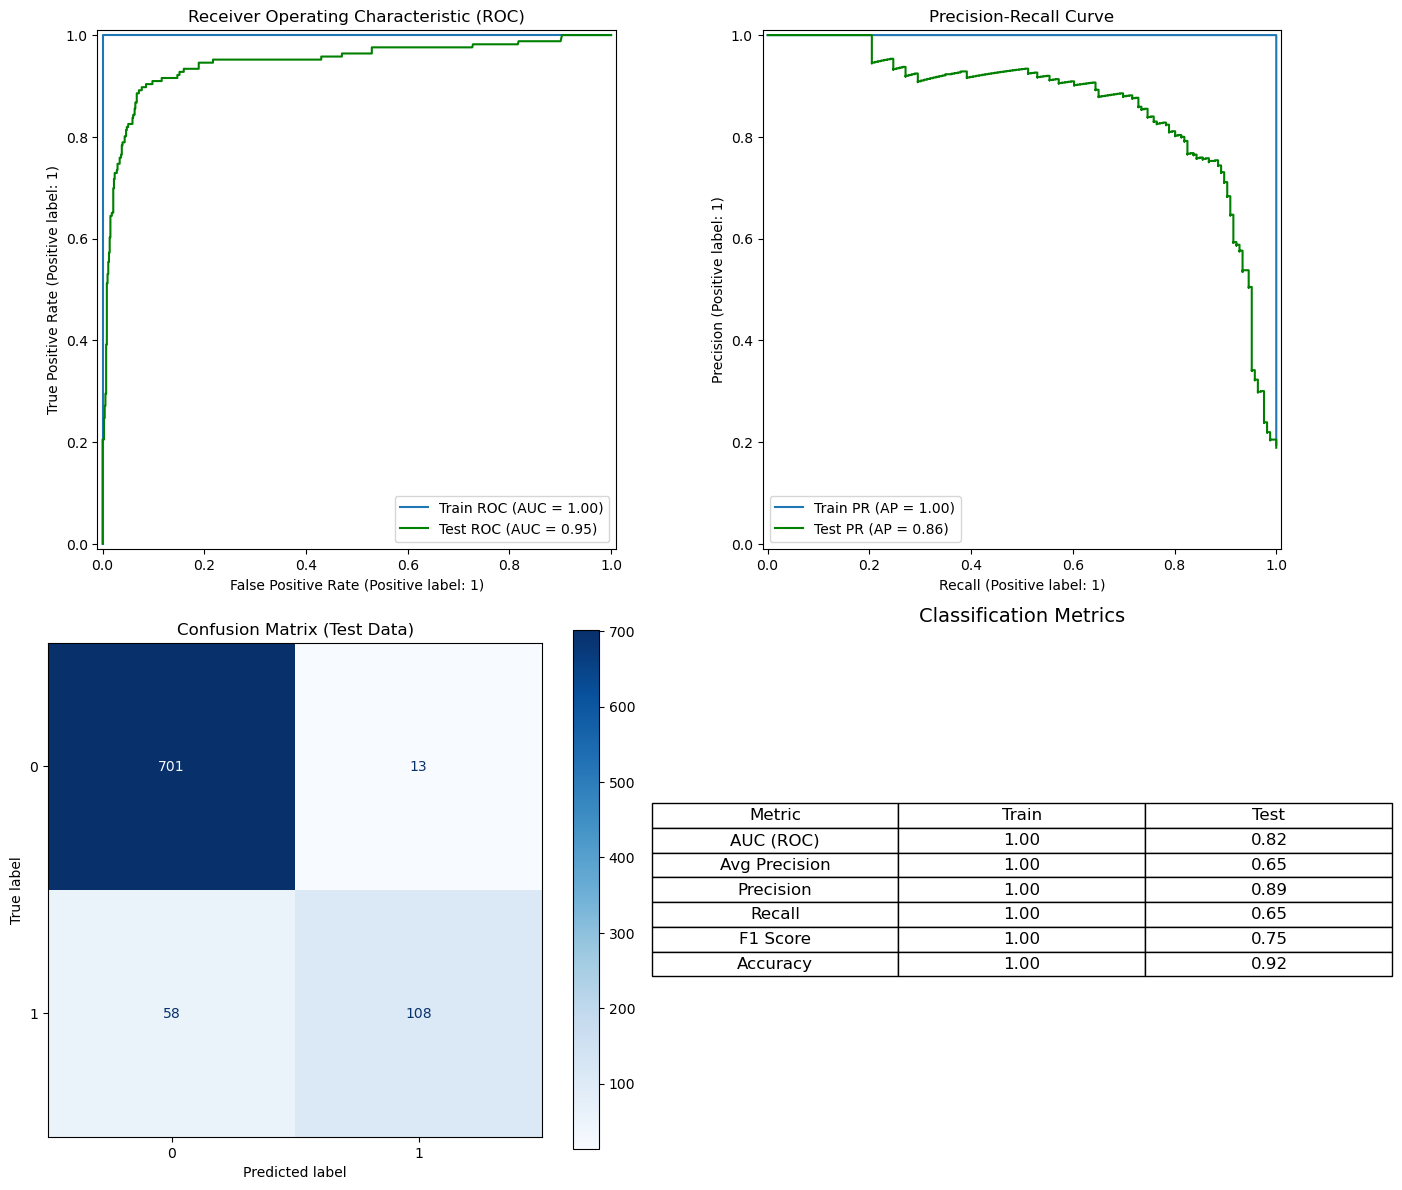

In [85]:
evaluate_binary_classification(plain_rf_grid)

#### B. Hyperparameter Tuning Using CSL and Random Over Sampling

In [89]:
ovrsamp_rf_grid = GridSearchCV(ovrsamp_rf,
                               param_grid = ovrsamp_rf_params,
                               scoring = scoring,
                               refit = refit_strategy,
                               cv = splitter,
                               verbose=1,
                               n_jobs=-1)

ovrsamp_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnImputer(steps=[('median_imputer',
                                                              SimpleImputer(strategy='median'),
                                                              ['Age',
                                                               'DurationOfPitch',
                                                               'NumberOfFollowups',
                                                               'PreferredPropertyStar',
                                                               'MonthlyIncome'])])),
                                       ('class_balancer',
                                        RandomOverSampler(random_state=6)),
                                       (...
             param_grid={'class_balancer__sampling_strategy': [0.3886516168395363,
                                                               0.6943258084197681,
                                                               1.0],
                         'model__class_weight': ['balanced', {0: 0.1, 1: 0.9},
                                                 {0: 0.5, 1: 0.5},
                                                 {0: 0.9,
                                                  1: 0.09999999999999998}],
                         'model__max_depth': [16, 20],
                         'model__min_samples_split': [3, 5],
                         'model__n_estimators': [50, 100]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [90]:
ovrsamp_rf_grid_cv_results = pd.DataFrame(ovrsamp_rf_grid.cv_results_)
#ovrsamp_rf_grid_cv_results.to_csv('./ovrsamp_rf_grid_cv_results.csv')
ovrsamp_rf_grid.best_params_

{'class_balancer__sampling_strategy': 1.0,
 'model__class_weight': {0: 0.1, 1: 0.9},
 'model__max_depth': 20,
 'model__min_samples_split': 3,
 'model__n_estimators': 100}

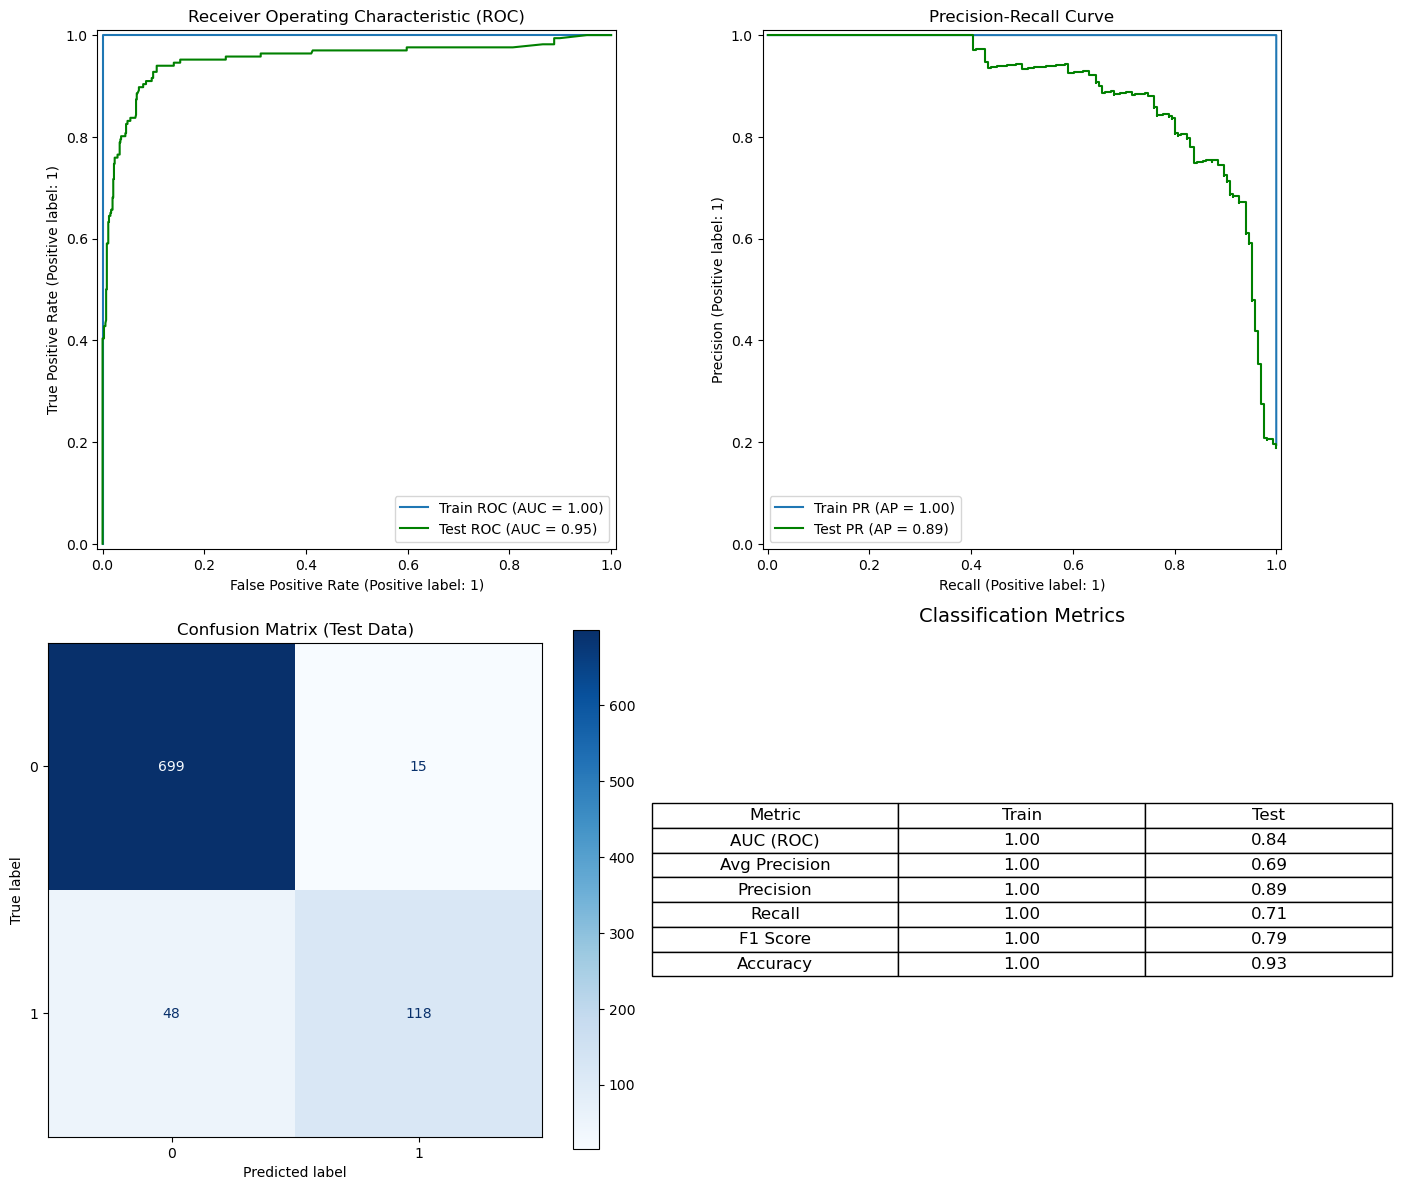

In [91]:
evaluate_binary_classification(ovrsamp_rf_grid)

#### C. Hyperparameter Tuning Using CSL and Synthetic Dataset

In [93]:
synsamp_rf_grid = GridSearchCV(synsamp_rf,
                               param_grid = synsamp_rf_params,
                               scoring = scoring,
                               refit = refit_strategy,
                               cv = splitter,
                               verbose=1,
                               n_jobs=-1)

synsamp_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnImputer(steps=[('median_imputer',
                                                              SimpleImputer(strategy='median'),
                                                              ['Age',
                                                               'DurationOfPitch',
                                                               'NumberOfFollowups',
                                                               'PreferredPropertyStar',
                                                               'MonthlyIncome'])])),
                                       ('class_balancer',
                                        SMOTENC(categorical_features=['Prefe...
             param_grid={'class_balancer__sampling_strategy': [0.3886516168395363,
                                                               0.6943258084197681,
                                                               1.0],
                         'model__class_weight': ['balanced', {0: 0.1, 1: 0.9},
                                                 {0: 0.5, 1: 0.5},
                                                 {0: 0.9,
                                                  1: 0.09999999999999998}],
                         'model__max_depth': [16, 20],
                         'model__min_samples_split': [3, 5],
                         'model__n_estimators': [50, 100]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [94]:
synsamp_rf_grid_cv_results = pd.DataFrame(synsamp_rf_grid.cv_results_)
#synsamp_rf_grid_cv_results.to_csv('./synsamp_rf_grid_cv_results.csv')
synsamp_rf_grid.best_params_

{'class_balancer__sampling_strategy': 0.3886516168395363,
 'model__class_weight': {0: 0.5, 1: 0.5},
 'model__max_depth': 20,
 'model__min_samples_split': 3,
 'model__n_estimators': 100}

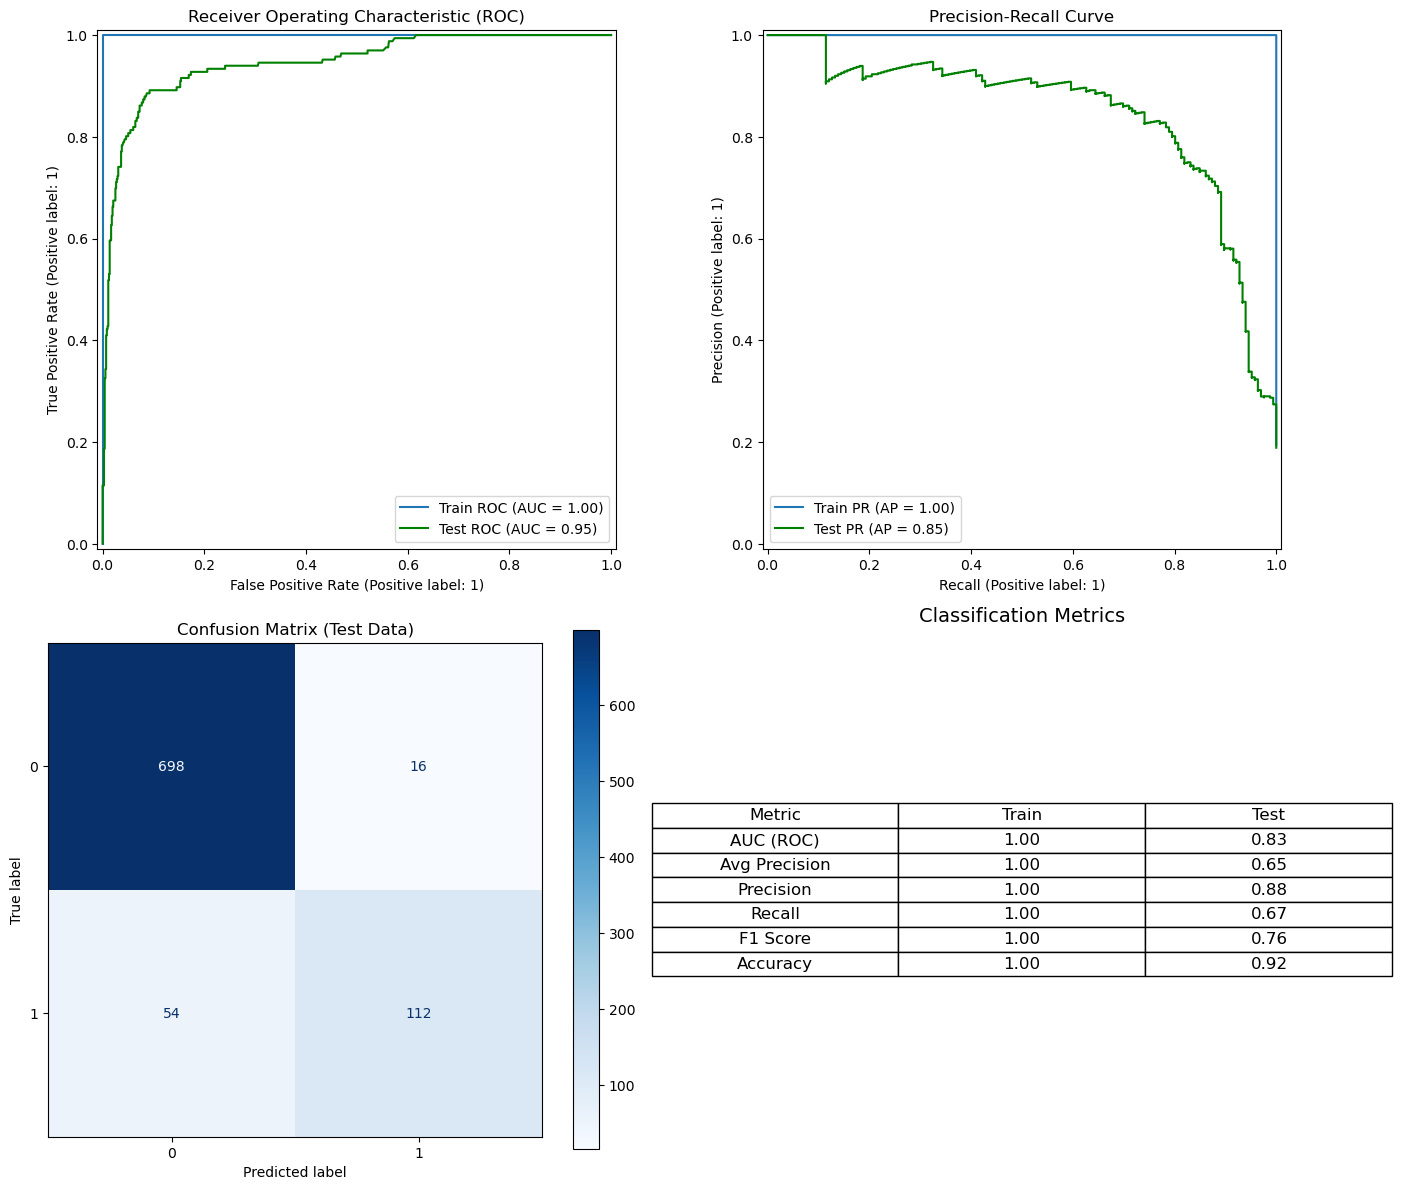

In [95]:
evaluate_binary_classification(synsamp_rf_grid)

### 5.1.3 Find The Most Evaluate Model

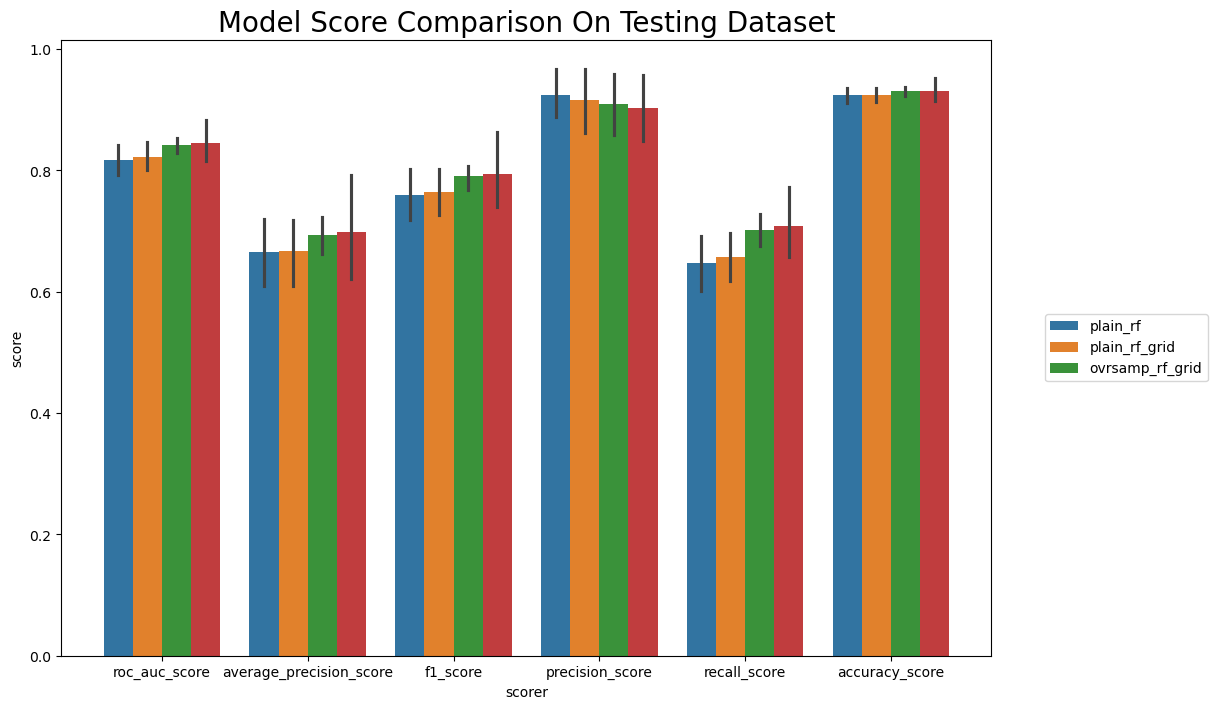

In [150]:
rf_grid_comparisons = plot_model_scores_comparisons(plain_rf, plain_rf_grid, ovrsamp_rf_grid, synsamp_rf_grid,
                                                    scorers=scorers, return_comparations_table=True)

## 5.2 Cat Boost

### 5.2.1 Create Pipeline Comparison

In [68]:
ovrsamp_cat_md = CatBoostClassifier(random_state=seed, verbose=False)
ovrsamp_cat = Pipeline([
    ('imputer', imputer),
    ('class_balancer', ros),
    ('encoder', encoder_lb),
    ('model', ovrsamp_cat_md)
])

synsamp_cat_md = CatBoostClassifier(random_state=seed, verbose=False)
synsamp_cat = Pipeline([
    ('imputer', imputer),
    ('class_balancer', smotenc),
    ('encoder', encoder_lb),
    ('model', synsamp_cat_md)
])

In [69]:
# Create Hyperparameters
class_weights = ['balanced']+[{0:i, 1:1-i} for i in np.linspace(0.1, 0.9, 3)]
depth = [4, 6, 10]
l2_leaf_reg = [1, 5, 10]
subsample = [0.6, 0.8, 1.0]
sampling_strategy = [IR+i for i in np.linspace(IR, 1-IR, 3)]


plain_cat_params = {
    'model__depth' : depth,
    'model__l2_leaf_reg' : l2_leaf_reg,
    'model__subsample' : subsample
}

ovrsamp_cat_params = {
    'class_balancer__sampling_strategy' : sampling_strategy,
    'model__depth' : depth,
    'model__l2_leaf_reg' : l2_leaf_reg,
    'model__subsample' : subsample
}

synsamp_cat_params = {
    'class_balancer__sampling_strategy' : sampling_strategy,
    'model__depth' : depth,
    'model__l2_leaf_reg' : l2_leaf_reg,
    'model__subsample' : subsample
}

### 5.2.2 GridSearch Models

#### A. Hyperparameters Tuning using CSL

In [150]:
plain_cat_grid = GridSearchCV(plain_cat,
                             param_grid = plain_cat_params,
                             scoring = scoring,
                             refit = refit_strategy,
                             cv = splitter,
                             verbose=1,
                             n_jobs=-1)

plain_cat_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('imputer',
                                                         ColumnImputer(steps=[('median_imputer',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Age',
                                                                                'DurationOfPitch',
                                                                                'NumberOfFollowups',
                                                                                'PreferredPropertyStar',
                                                                                'MonthlyIncome'])])),
                                                        ('encoder',
                                                         <__main__.ICode object at 0x00000142174AA940>)])),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x0000014214584070>)]),
             n_jobs=-1,
             param_grid={'model__depth': [4, 6, 10],
                         'model__l2_leaf_reg': [1, 5, 10],
                         'model__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [ ]:
plain_cat_grid_cv_results = pd.DataFrame(plain_cat_grid.cv_results_)
plain_cat_grid_cv_results.to_csv('./plain_cat_grid_cv_results.csv')
plain_cat_grid.best_params_

In [ ]:
evaluate_binary_classification(plain_cat_grid)

#### B. Hyperparameter Tuning Using CSL and Random Over Sampling

In [154]:
ovrsamp_cat_grid = GridSearchCV(ovrsamp_cat,
                                param_grid = ovrsamp_cat_params,
                                scoring = scoring,
                                refit = refit_strategy,
                                cv = splitter,
                                verbose=1,
                                 n_jobs=-1)

ovrsamp_cat_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnImputer(steps=[('median_imputer',
                                                              SimpleImputer(strategy='median'),
                                                              ['Age',
                                                               'DurationOfPitch',
                                                               'NumberOfFollowups',
                                                               'PreferredPropertyStar',
                                                               'MonthlyIncome'])])),
                                       ('class_balancer',
                                        RandomOverSampler(random_state=6)),
                                       (...
                                        <catboost.core.CatBoostClassifier object at 0x00000142224246D0>)]),
             n_jobs=-1,
             param_grid={'class_balancer__sampling_strategy': [0.3886516168395363,
                                                               0.6943258084197681,
                                                               1.0],
                         'model__depth': [4, 6, 10],
                         'model__l2_leaf_reg': [1, 5, 10],
                         'model__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [ ]:
ovrsamp_cat_grid_cv_results = pd.DataFrame(ovrsamp_cat_grid.cv_results_)
ovrsamp_cat_grid_cv_results.to_csv('./ovrsamp_cat_grid_cv_results.csv')
ovrsamp_cat_grid.best_params_

In [ ]:
evaluate_binary_classification(ovrsamp_cat_grid)

#### C. Hyperparameter Tuning Using CSL and Synthetic Dataset

In [96]:
synsamp_cat_grid = GridSearchCV(synsamp_cat,
                                param_grid = synsamp_cat_params,
                                scoring = scoring,
                                refit = refit_strategy,
                                cv = splitter,
                                verbose=1,
                                n_jobs=-1)

synsamp_cat_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnImputer(steps=[('median_imputer',
                                                              SimpleImputer(strategy='median'),
                                                              ['Age',
                                                               'DurationOfPitch',
                                                               'NumberOfFollowups',
                                                               'PreferredPropertyStar',
                                                               'MonthlyIncome'])])),
                                       ('class_balancer',
                                        SMOTENC(categorical_features=['Prefe...
                                        <catboost.core.CatBoostClassifier object at 0x00000173FA1BD610>)]),
             n_jobs=-1,
             param_grid={'class_balancer__sampling_strategy': [0.3886516168395363,
                                                               0.6943258084197681,
                                                               1.0],
                         'model__depth': [4, 6, 10],
                         'model__l2_leaf_reg': [1, 5, 10],
                         'model__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [ ]:
synsamp_cat_grid_cv_results = pd.DataFrame(synsamp_cat_grid.cv_results_)
synsamp_cat_grid_cv_results.to_csv('./synsamp_cat_grid_cv_results.csv')
synsamp_cat_grid.best_params_

In [ ]:
evaluate_binary_classification(synsamp_cat_grid)

### 5.2.3 Evaluate Models

In [ ]:
cat_grid_comparisons = plot_model_scores_comparisons(plain_cat, plain_cat_grid, ovrsamp_cat_grid, synsamp_cat_grid,
                                                    scorers=scorers, return_comparations_table=True)

## 5.3 XGBoost

### 5.3.1 Create Pipeline Comparison

In [228]:
# Create Hyperparameters
n_estimators = [50, 100, 200]
learning_rate = [0.01, 0.1, 0.2]
max_depth = [3, 5, 7]
subsample = [0.8, 1.0]
colsample_bytree = [0.8, 1.0]
sampling_strategy = [IR+i for i in np.linspace(IR, 1-IR, 3)]
class_weights = ['balanced']+[{0:i, 1:1-i} for i in np.linspace(0.1, 0.9, 3)]


plain_xgb_params = {
    'model__n_estimators': n_estimators,
    'model__class_weights' : class_weights,
    'model__max_depth': max_depth,
    'model__subsample': subsample,
    'model__colsample_bytree': colsample_bytree
}

ovrsamp_xgb_params = {
    'class_balancer__sampling_strategy' : sampling_strategy,
    'model__class_weights' : class_weights,
    'model__n_estimators': n_estimators,
    'model__max_depth': max_depth,
    'model__subsample': subsample,
    'model__colsample_bytree': colsample_bytree
}

synsamp_xgb_params = {
    'class_balancer__sampling_strategy' : sampling_strategy,
    'model__class_weights' : class_weights,
    'model__n_estimators': n_estimators,
    'model__max_depth': max_depth,
    'model__subsample': subsample,
    'model__colsample_bytree': colsample_bytree
}

In [229]:
ovrsamp_xgb_md = XGBClassifier(random_state=seed, verbose=False)
ovrsamp_xgb = Pipeline([
    ('imputer', imputer),
    ('class_balancer', ros),
    ('encoder', encoder_lb),
    ('model', ovrsamp_xgb_md)
])

synsamp_xgb_md = XGBClassifier(random_state=seed, verbose=False)
synsamp_xgb = Pipeline([
    ('imputer', imputer),
    ('class_balancer', smotenc),
    ('encoder', encoder_lb),
    ('model', ovrsamp_xgb_md)
])

### 5.3.2 GridSearch Models

#### A. Hyperparameter Tuning Using CSL

In [232]:
plain_xgb_grid = GridSearchCV(plain_xgb,
                             param_grid = plain_xgb_params,
                             scoring = scoring,
                             refit = refit_strategy,
                             cv = splitter,
                             verbose=1,
                             n_jobs=-1)

plain_xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('imputer',
                                                         ColumnImputer(steps=[('median_imputer',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Age',
                                                                                'DurationOfPitch',
                                                                                'NumberOfFollowups',
                                                                                'PreferredPropertyStar',
                                                                                'MonthlyIncome'])])),
                                                        ('encoder',
                                                         <__main__.I...
             n_jobs=-1,
             param_grid={'model__class_weights': ['balanced', {0: 0.1, 1: 0.9},
                                                  {0: 0.5, 1: 0.5},
                                                  {0: 0.9,
                                                   1: 0.09999999999999998}],
                         'model__colsample_bytree': [0.8, 1.0],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.8, 1.0]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [233]:
plain_xgb_grid_cv_results = pd.DataFrame(plain_xgb_grid.cv_results_)
#plain_xgb_grid_cv_results.to_csv('./plain_xgb_grid_cv_results.csv')
plain_xgb_grid.best_params_

{'model__class_weights': 'balanced',
 'model__colsample_bytree': 0.8,
 'model__max_depth': 7,
 'model__n_estimators': 200,
 'model__subsample': 1.0}

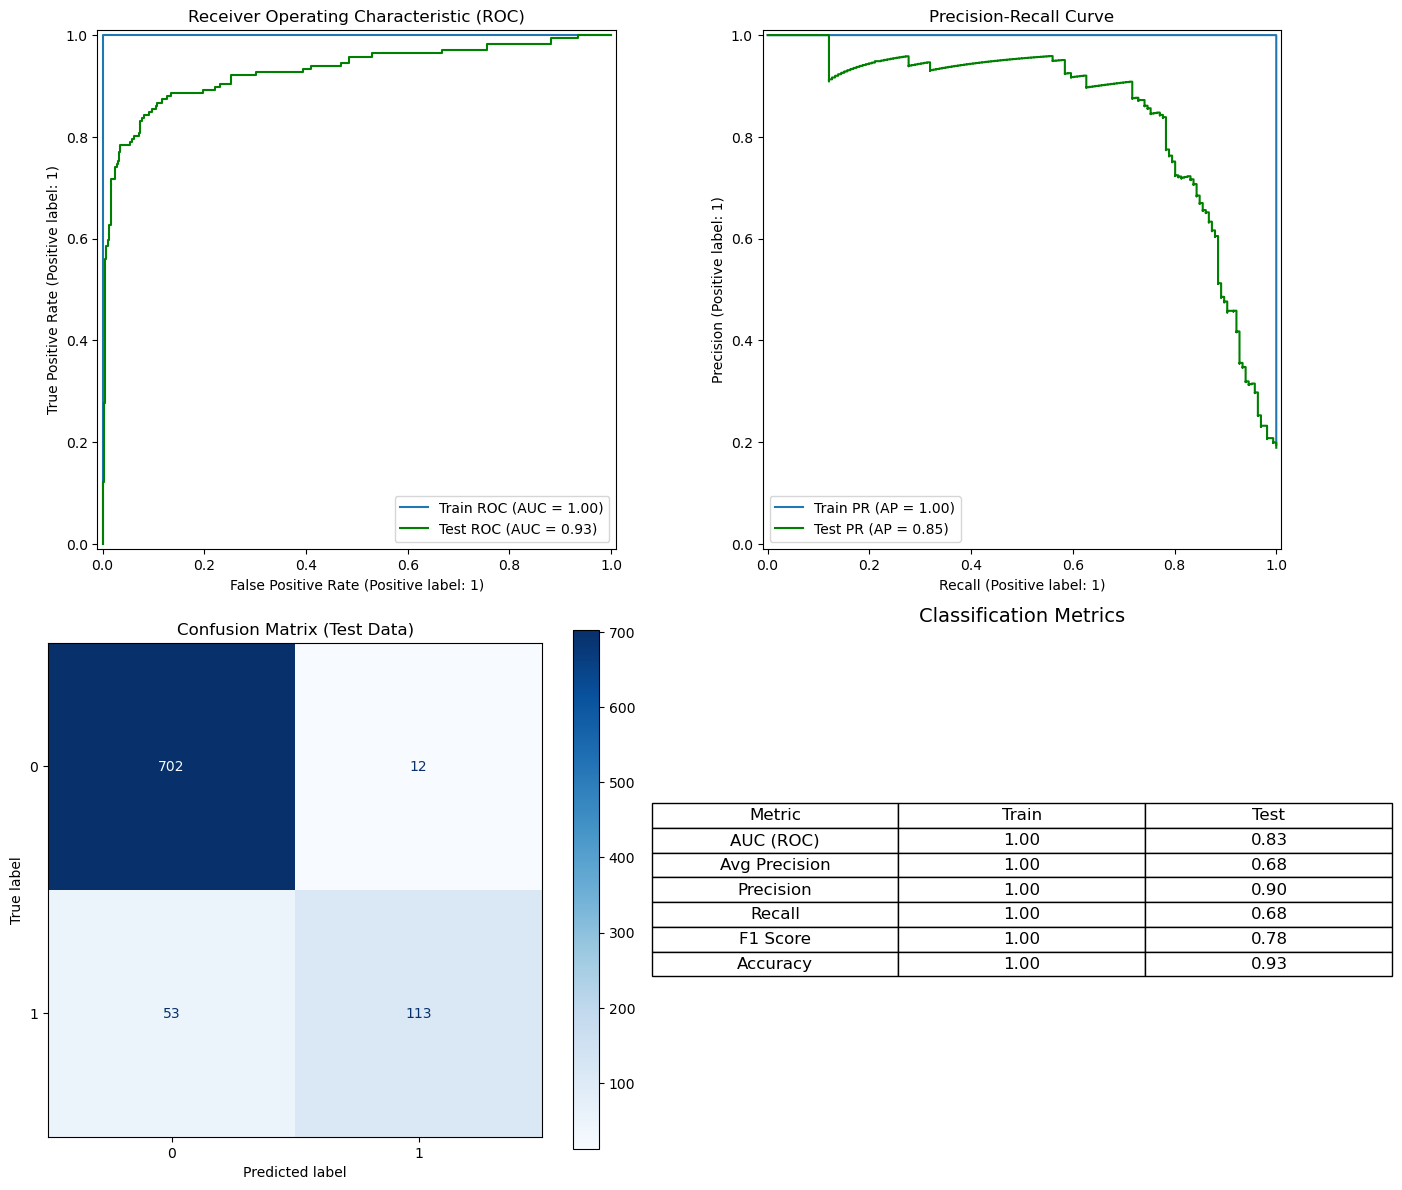

In [234]:
evaluate_binary_classification(plain_xgb_grid)

#### B. Hyperparameter Tuning Using CSL and Random Over Sampling

In [235]:
ovrsamp_xgb_grid = GridSearchCV(ovrsamp_xgb,
                             param_grid = ovrsamp_xgb_params,
                             scoring = scoring,
                             refit = refit_strategy,
                             cv = splitter,
                             verbose=1,
                             n_jobs=-1)

ovrsamp_xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnImputer(steps=[('median_imputer',
                                                              SimpleImputer(strategy='median'),
                                                              ['Age',
                                                               'DurationOfPitch',
                                                               'NumberOfFollowups',
                                                               'PreferredPropertyStar',
                                                               'MonthlyIncome'])])),
                                       ('class_balancer',
                                        RandomOverSampler(random_state=6)),
                                       (...
                                                               0.6943258084197681,
                                                               1.0],
                         'model__class_weights': ['balanced', {0: 0.1, 1: 0.9},
                                                  {0: 0.5, 1: 0.5},
                                                  {0: 0.9,
                                                   1: 0.09999999999999998}],
                         'model__colsample_bytree': [0.8, 1.0],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.8, 1.0]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [236]:
ovrsamp_xgb_grid_cv_results = pd.DataFrame(ovrsamp_xgb_grid.cv_results_)
#ovrsamp_xgb_grid_cv_results.to_csv('./ovrsamp_xgb_grid_cv_results.csv')
ovrsamp_xgb_grid.best_params_

{'class_balancer__sampling_strategy': 1.0,
 'model__class_weights': 'balanced',
 'model__colsample_bytree': 1.0,
 'model__max_depth': 7,
 'model__n_estimators': 200,
 'model__subsample': 1.0}

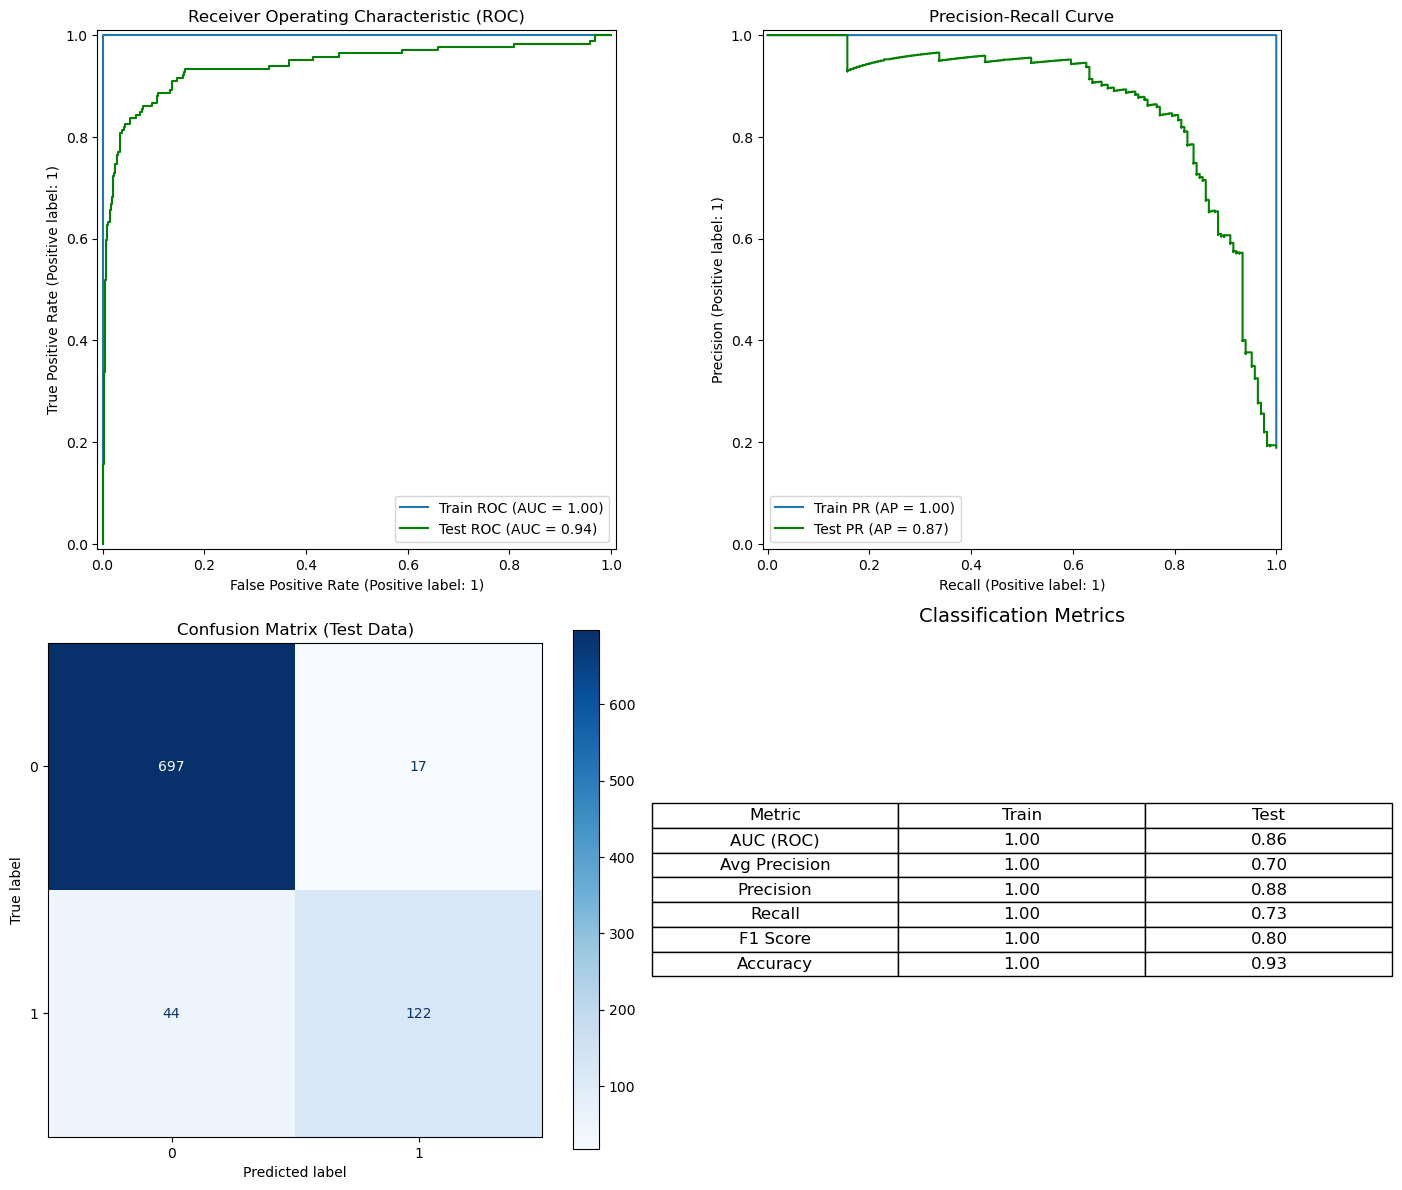

In [237]:
evaluate_binary_classification(ovrsamp_xgb_grid)

#### C. Hyperparameter Tuning Using CSL and Synthetic Dataset

In [238]:
synsamp_xgb_grid = GridSearchCV(synsamp_xgb,
                             param_grid = synsamp_xgb_params,
                             scoring = scoring,
                             refit = refit_strategy,
                             cv = splitter,
                             verbose=1,
                             n_jobs=-1)

synsamp_xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=6, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('imputer',
                                        ColumnImputer(steps=[('median_imputer',
                                                              SimpleImputer(strategy='median'),
                                                              ['Age',
                                                               'DurationOfPitch',
                                                               'NumberOfFollowups',
                                                               'PreferredPropertyStar',
                                                               'MonthlyIncome'])])),
                                       ('class_balancer',
                                        SMOTENC(categorical_features=['Prefe...
                                                               0.6943258084197681,
                                                               1.0],
                         'model__class_weights': ['balanced', {0: 0.1, 1: 0.9},
                                                  {0: 0.5, 1: 0.5},
                                                  {0: 0.9,
                                                   1: 0.09999999999999998}],
                         'model__colsample_bytree': [0.8, 1.0],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.8, 1.0]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'precision', 'recall',
                      'f1', 'accuracy'],
             verbose=1)

In [239]:
synsamp_xgb_grid_cv_results = pd.DataFrame(synsamp_xgb_grid.cv_results_)
#synsamp_xgb_grid_cv_results.to_csv('./synsamp_xgb_grid_cv_results.csv')
synsamp_xgb_grid.best_params_

{'class_balancer__sampling_strategy': 0.3886516168395363,
 'model__class_weights': 'balanced',
 'model__colsample_bytree': 0.8,
 'model__max_depth': 7,
 'model__n_estimators': 200,
 'model__subsample': 1.0}

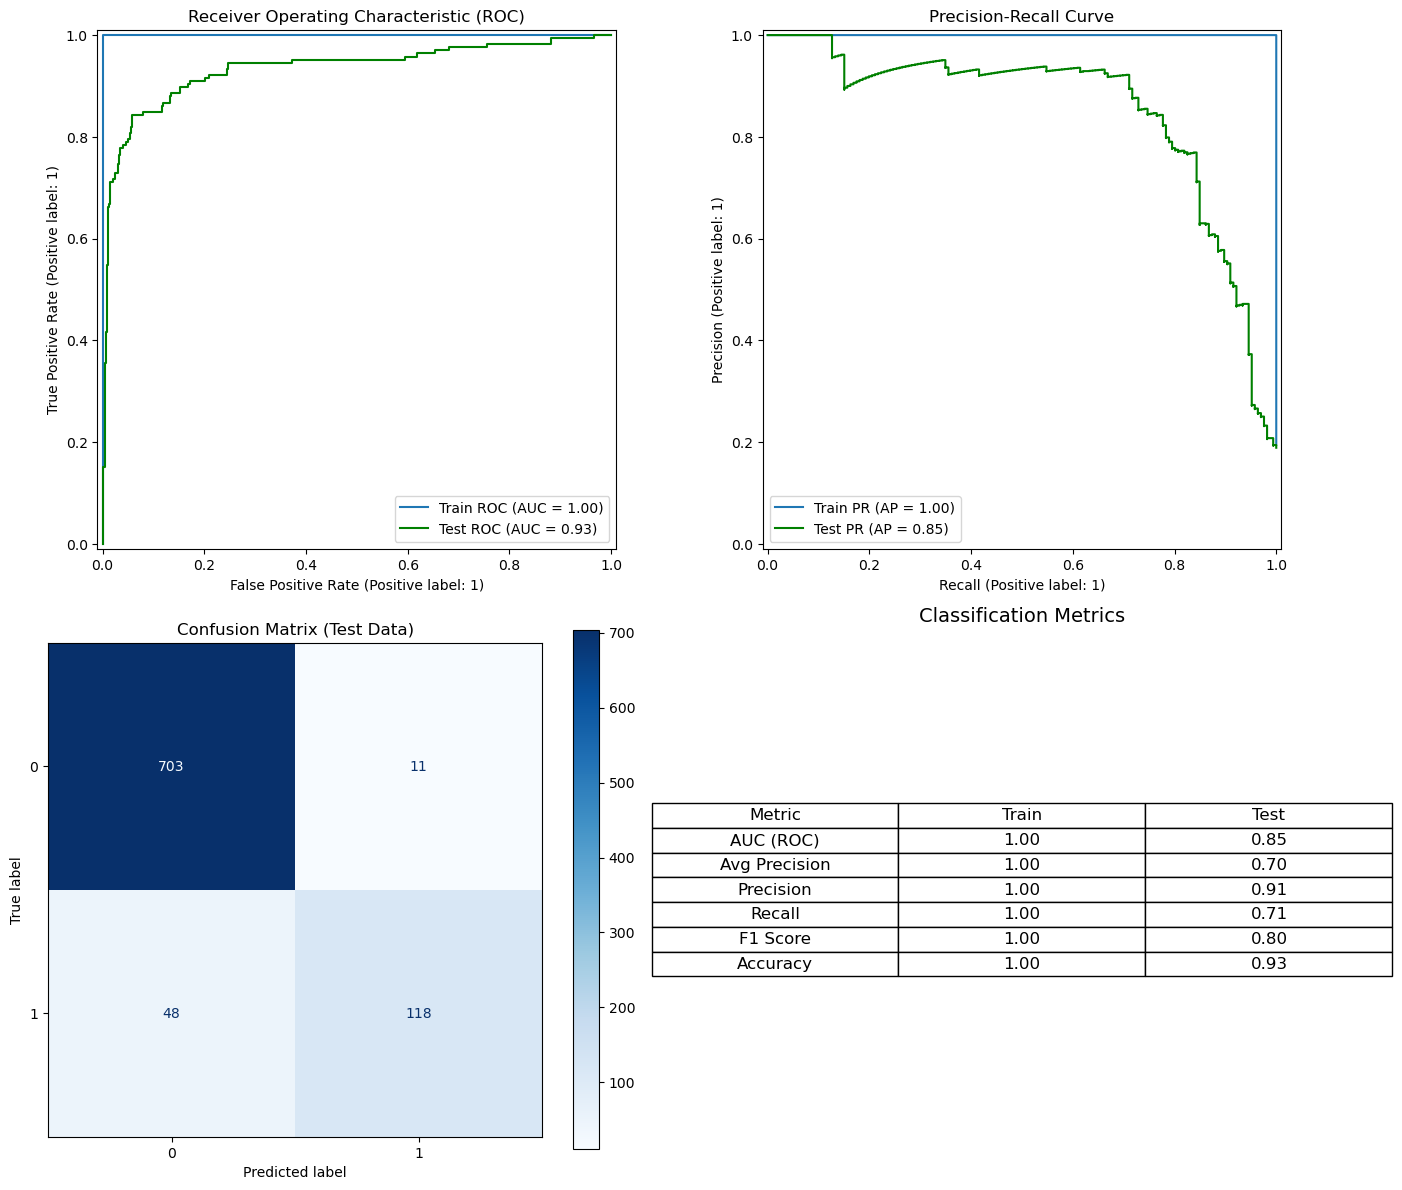

In [240]:
evaluate_binary_classification(synsamp_xgb_grid)

### 5.3.3 Evaluate Models

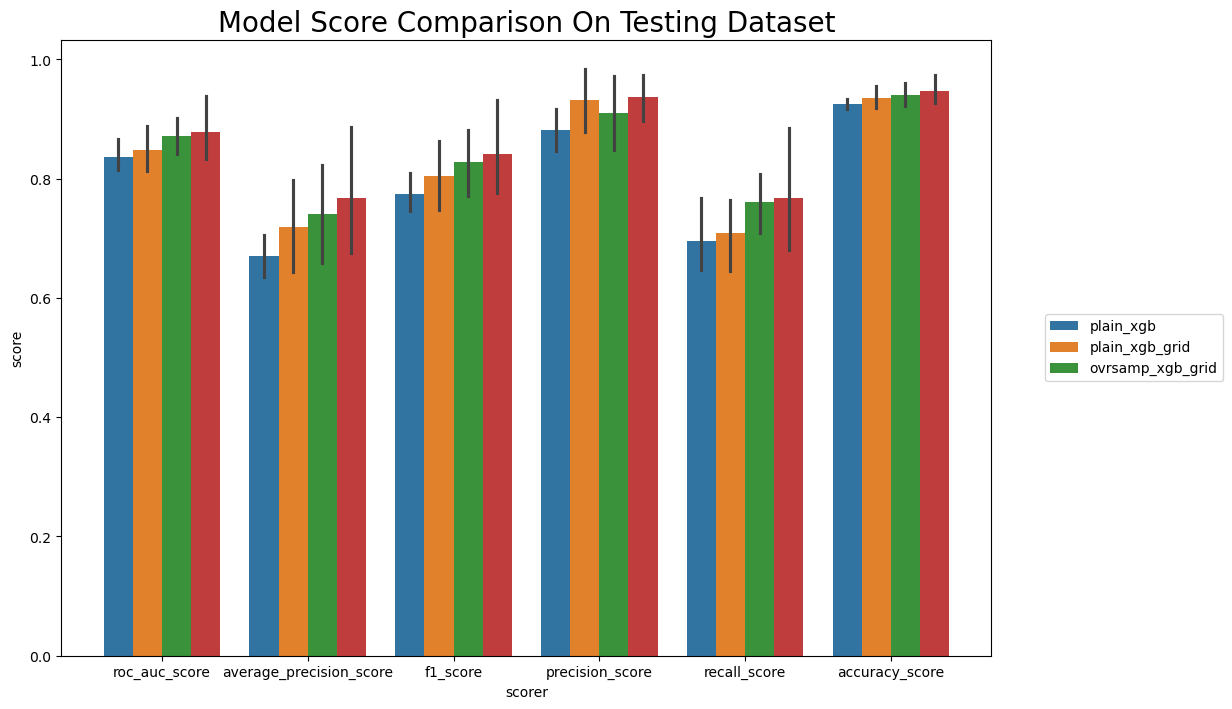

In [267]:
xgb_grid_comparisons = plot_model_scores_comparisons(plain_xgb, plain_xgb_grid, ovrsamp_xgb_grid, synsamp_xgb_grid,
                                                    scorers=scorers, return_comparations_table=True)

## 5.4 Choose One Model

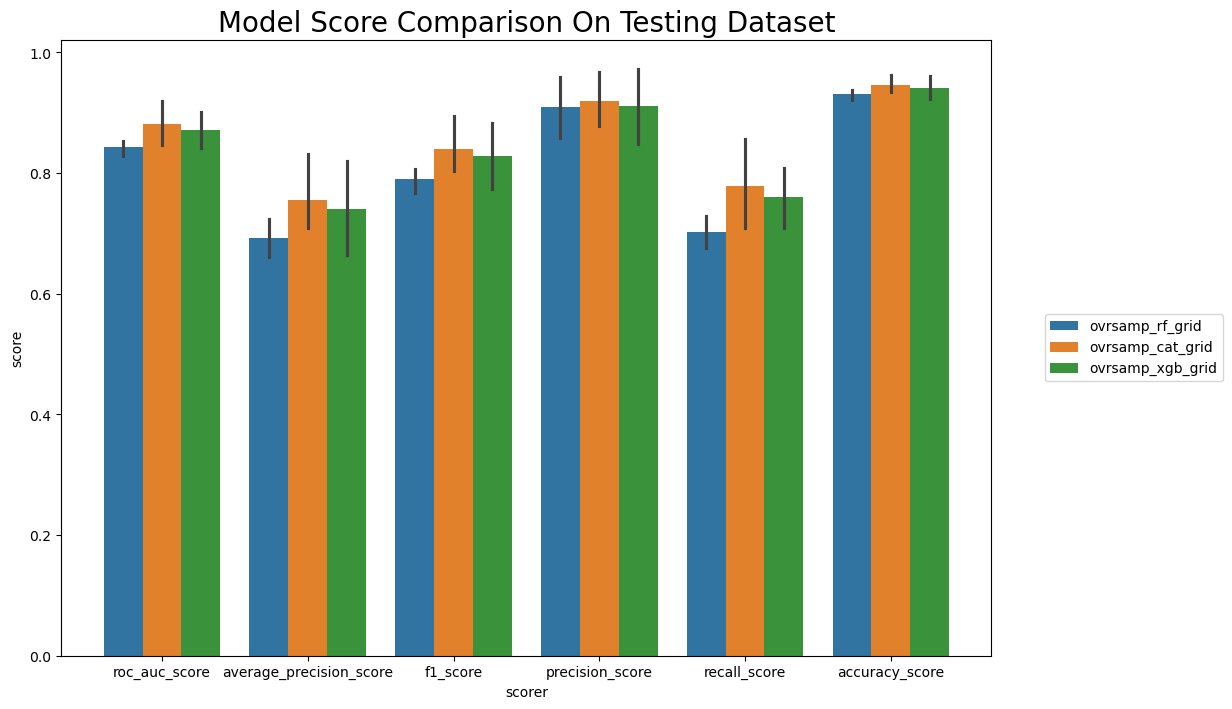

In [268]:
all_model_comparisons = plot_model_scores_comparisons(ovrsamp_rf_grid,
                                                      ovrsamp_cat_grid,
                                                      ovrsamp_xgb_grid,
                                                      random_state = 6,
                                                      
                                                    scorers=scorers, return_comparations_table=True)

In [269]:
compare_model_table(all_model_comparisons)

mean score                                   \
model                   ovrsamp_cat_grid ovrsamp_rf_grid ovrsamp_xgb_grid   
scorer                                                                      
accuracy_score                     94.51           93.00            94.07   
average_precision_score            75.60           69.29            74.10   
f1_score                           83.91           79.03            82.82   
precision_score                    91.94           90.86            91.04   
recall_score                       77.76           70.17            76.02   
roc_auc_score                      88.05           84.22            87.13   

                               std score                                   
model                   ovrsamp_cat_grid ovrsamp_rf_grid ovrsamp_xgb_grid  
scorer                                                                     
accuracy_score                      1.89            1.00             2.45  
average_precision_score             8.33            4.28            10.69  
f1_score                            5.96            2.64             7.07  
precision_score                     5.84            6.57             8.21  
recall_score                        9.66            3.36             6.51  
roc_auc_score                       4.77            1.55             3.96

In [244]:
rf_mean_fit_time = ovrsamp_rf_grid.cv_results_['mean_fit_time'].mean()
rf_std_fit_time = ovrsamp_rf_grid.cv_results_['mean_fit_time'].std()

In [245]:
xgb_mean_fit_time = ovrsamp_xgb_grid.cv_results_['mean_fit_time'].mean()
xgb_std_fit_time = ovrsamp_xgb_grid.cv_results_['mean_fit_time'].std()

In [246]:
cat_mean_fit_time = ovrsamp_cat_grid.cv_results_['mean_fit_time'].mean()
cat_std_fit_time = ovrsamp_cat_grid.cv_results_['mean_fit_time'].std()

In [247]:
print(f"{rf_mean_fit_time :.2f} (std. {rf_std_fit_time :.2f})")

0.93 (std. 0.34)


In [248]:
print(f"{xgb_mean_fit_time :.2f} (std. {xgb_std_fit_time :.2f})")

0.39 (std. 0.13)


In [249]:
print(f"{cat_mean_fit_time :.2f} (std. {cat_std_fit_time :.2f})")

20.12 (std. 15.16)


# 6. Model Calibration

In [192]:
from sklearn.calibration import CalibrationDisplay

In [193]:
def expected_calibration_error(labels, probabilities, n_bins=20):
    """
    Calculate Expected Calibration Error (ECE).
    
    :param probabilities: Array of predicted probabilities (for the positive class in binary classification).
    :param labels: Array of true labels (0 or 1).
    :param n_bins: Number of bins for discretizing the probability space.
    :return: ECE score.
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)  # Create bin boundaries.
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2  # Midpoints of each bin.

    ece = 0.0  # Initialize the ECE score.

    for i in range(n_bins):
        # Get indices of probabilities that fall into the current bin.
        bin_indices = (probabilities >= bin_boundaries[i]) & (probabilities < bin_boundaries[i + 1])

        if np.any(bin_indices):  # If there are samples in this bin.
            bin_accuracy = np.mean(labels[bin_indices])  # Accuracy in the bin.
            bin_confidence = np.mean(probabilities[bin_indices])  # Mean predicted probability in the bin.
            bin_prob = np.mean(bin_indices)  # Proportion of samples in this bin.

            # Add weighted difference between bin accuracy and confidence to the ECE score.
            ece += np.abs(bin_confidence - bin_accuracy) * bin_prob

    return ece

In [194]:
probs_uncalibrated = ovrsamp_xgb_grid.predict_proba(X_test)[:,-1]
ece_score_uncalibrated = expected_calibration_error(y_test, probs_uncalibrated)

print(f"""
Uncalibrated Model:
ECE Loss = {ece_score_uncalibrated :.4f}
""")


Uncalibrated Model:
ECE Loss = 0.0417



## 6.1 Plot Before Calibrations

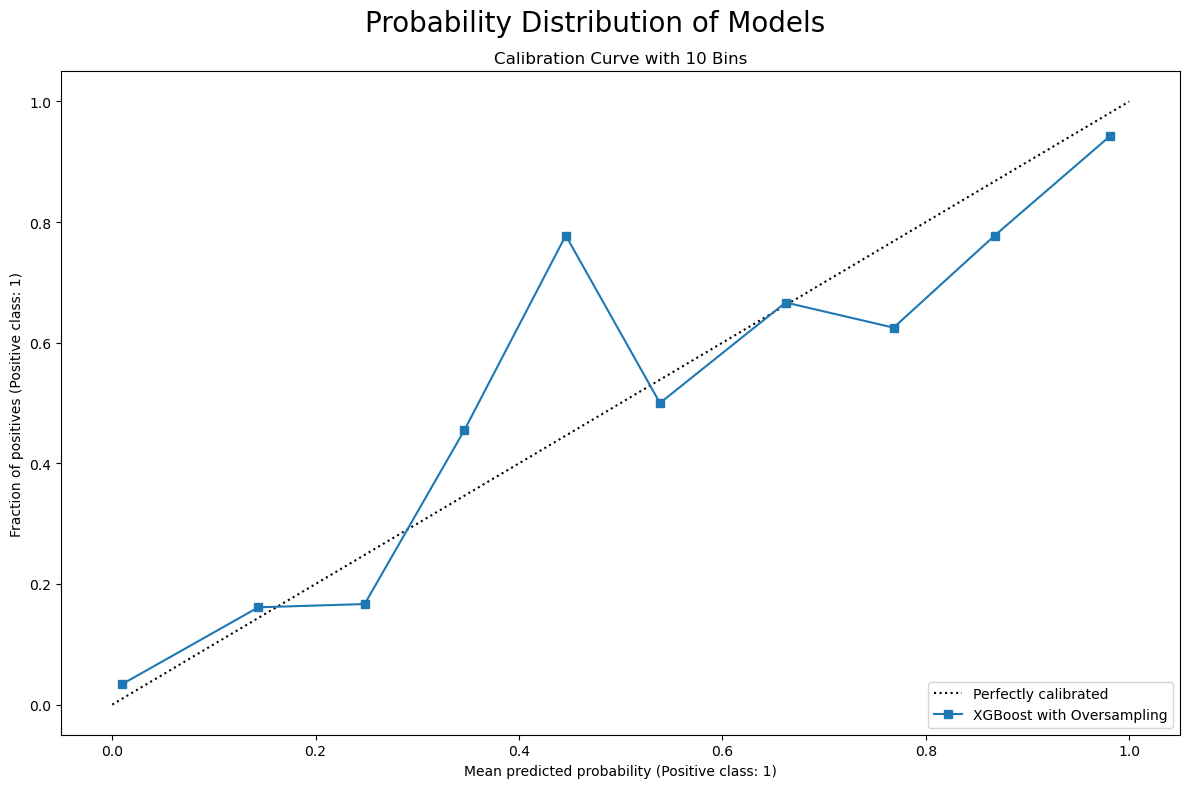

In [258]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

classifier_name = "XGBoost with Oversampling"
disp = CalibrationDisplay.from_predictions(y_test, probs_uncalibrated, name = classifier_name,
                                            n_bins=10, ax = ax)
ax.set_title("Calibration Curve with 10 Bins")

fig.suptitle("Probability Distribution of Models", size=20)
fig.tight_layout()

## 6.2 Calibration Process

In [259]:
from sklearn.calibration import CalibratedClassifierCV

In [260]:
platt_scaling = CalibratedClassifierCV(ovrsamp_xgb_grid,
                                       method='sigmoid', cv = 'prefit')
platt_scaling.fit(X_cal, y_cal)
probs_ps = platt_scaling.predict_proba(X_test)[:, -1]
ece_score_ps = expected_calibration_error(y_test, probs_ps)

isotonic_regression = CalibratedClassifierCV(ovrsamp_xgb_grid,
                                             method='isotonic', cv='prefit')
isotonic_regression.fit(X_cal, y_cal)
probs_ir = isotonic_regression.predict_proba(X_test)[:, -1]
ece_score_ir = expected_calibration_error(y_test, probs_ir)

## 6.3 Plot After Calibrations

In [261]:
print(f"""
Uncalibrated Model:
ECE Loss = {ece_score_uncalibrated :.4f}

======================================================

Platt Scaling Calibrated Model:
ECE Loss = {ece_score_ps :.4f}

======================================================

Isotonic Regression Calibration Model:
ECE Loss = {ece_score_ir :.4f}
""")


Uncalibrated Model:
ECE Loss = 0.0417


Platt Scaling Calibrated Model:
ECE Loss = 0.0404


Isotonic Regression Calibration Model:
ECE Loss = 0.0237



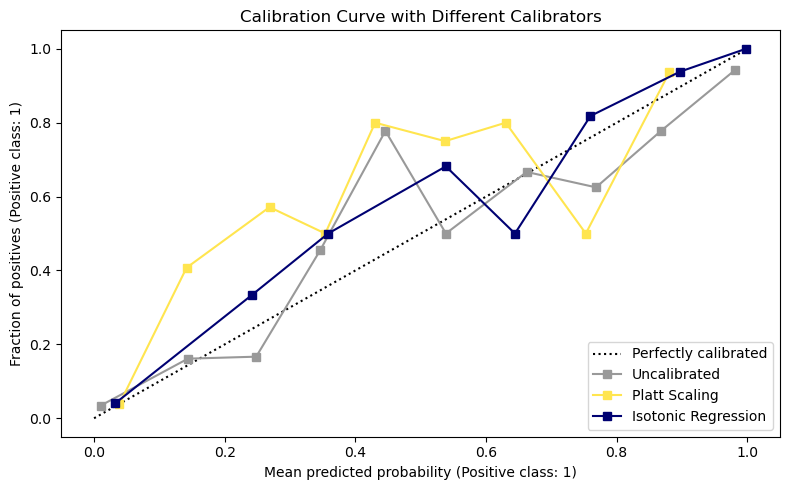

In [262]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

uncalibrated_color, ps_color, ir_color = '#999999', '#ffe54f', '#000172'

disp31 = CalibrationDisplay.from_predictions(y_test, probs_uncalibrated, name = "Uncalibrated",
                                            n_bins = 10, ax = ax, color = uncalibrated_color)
disp32 = CalibrationDisplay.from_predictions(y_test, probs_ps, name = "Platt Scaling",
                                            n_bins = 10, ax = ax, color = ps_color)
disp33 = CalibrationDisplay.from_predictions(y_test, probs_ir, name = "Isotonic Regression",
                                            n_bins = 10, ax = ax, color = ir_color)

ax.set_title("Calibration Curve with Different Calibrators")
fig.tight_layout()

In [270]:
final_model_calibrated = isotonic_regression

# 7. Save Built Model

In [65]:
import pickle

## 7.1 Random Forest

### 7.1.1 Save

In [96]:
# Random Forest
with open('Model/plain_rf_grid.pkl', 'wb') as f:
    pickle.dump(plain_rf_grid, f)

with open('Model/ovrsamp_rf_grid.pkl', 'wb') as f:
    pickle.dump(ovrsamp_rf_grid, f)

with open('Model/synsamp_rf_grid.pkl', 'wb') as f:
    pickle.dump(synsamp_rf_grid, f)

### 7.1.2 Load

In [66]:
with open('Model/plain_rf_grid.pkl', 'rb') as f:
    plain_rf_grid = pickle.load(f)

with open('Model/ovrsamp_rf_grid.pkl', 'rb') as f:
    ovrsamp_rf_grid = pickle.load(f)

with open('Model/synsamp_rf_grid.pkl', 'rb') as f:
    synsamp_rf_grid = pickle.load(f)

## 7.2 Cat Boost

### 7.2.1 Save

In [ ]:
# CatBoost
with open('Model/plain_cat_grid.pkl', 'wb') as f:
    pickle.dump(plain_cat_grid, f)

with open('Model/ovrsamp_cat_grid.pkl', 'wb') as f:
    pickle.dump(ovrsamp_cat_grid, f)

with open('Model/synsamp_cat_grid.pkl', 'wb') as f:
    pickle.dump(synsamp_cat_grid, f)

### 7.2.2 Load

In [67]:
with open('Model/plain_cat_grid.pkl', 'rb') as f:
    plain_cat_grid = pickle.load(f)

with open('Model/ovrsamp_cat_grid.pkl', 'rb') as f:
    ovrsamp_cat_grid = pickle.load(f)

with open('Model/synsamp_cat_grid.pkl', 'rb') as f:
    synsamp_cat_grid = pickle.load(f)

## 7.3 XGBoost

### 7.3.1 Save

In [276]:
# XGBoost
with open('Model/plain_xgb_grid.pkl', 'wb') as f:
    pickle.dump(plain_xgb_grid, f)

with open('Model/ovrsamp_xgb_grid.pkl', 'wb') as f:
    pickle.dump(ovrsamp_xgb_grid, f)

with open('Model/synsamp_xgb_grid.pkl', 'wb') as f:
    pickle.dump(synsamp_xgb_grid, f)

### 7.3.2 Load

In [68]:
with open('Model/plain_xgb_grid.pkl', 'rb') as f:
    plain_xgb_grid = pickle.load(f)

with open('Model/ovrsamp_xgb_grid.pkl', 'rb') as f:
    ovrsamp_xgb_grid = pickle.load(f)

with open('Model/synsamp_xgb_grid.pkl', 'rb') as f:
    synsamp_xgb_grid = pickle.load(f)

## 7.4 Final Model
### 7.4.1 Save

In [275]:
# Final Model
with open('Model/final_model_calibrated.pkl', 'wb') as f:
    pickle.dump(final_model_calibrated, f)

### 7.4.2 Load

In [69]:
with open('Model/final_model_calibrated.pkl', 'rb') as f:
    final_model_calibrated = pickle.load(f)

# 8 Explain The Models

## 8.1 Model Feature Importances

In [98]:
importances_score = final_model_calibrated.estimator.best_estimator_['model'].feature_importances_
features_names = final_model_calibrated.estimator.best_estimator_['model'].feature_names_in_

In [99]:
#save results in Pandas DataFrame
feature_importances_df  = pd.DataFrame(np.concatenate([np.array(importances_score).reshape(-1,1), 
                                                       np.array(features_names).reshape(-1,1)], axis=1), 
                                       columns=['importances','features'])
feature_importances_df.importances = feature_importances_df.importances.astype('float64')

In [100]:
feature_importances_df.importances = 100*feature_importances_df.importances
feature_importances_df.sort_values(by='importances', ascending=False)

importances                features
10    22.999406             HasPassport
4     13.991920             Designation
3     10.126510           MaritalStatus
1      8.761803                CityTier
0      6.587686   PreferredPropertyStar
6      6.257695         DurationOfPitch
11     6.013873  PitchSatisfactionScore
5      5.855915                     Age
7      5.776632       NumberOfFollowups
2      5.545868              Occupation
9      4.399335              GenderMale
8      3.683356           MonthlyIncome

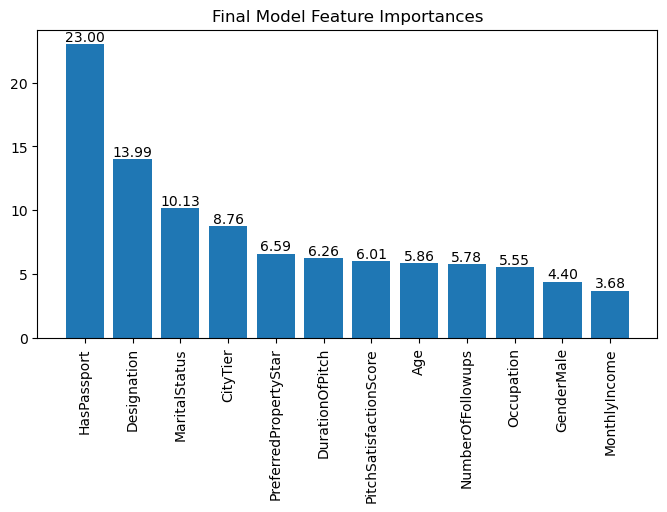

In [101]:
f, x = plt.subplots(1,1, figsize=(8,4))

feature_importances_df.sort_values(by='importances', ascending=False, inplace=True)

bars = plt.bar(feature_importances_df.features, feature_importances_df.importances, axes=x)
plt.xticks(rotation=90)
plt.title("Final Model Feature Importances")

# Add annotations to display the values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{height:.2f}', ha='center', va='bottom')

plt.show()


## 8.2 Shap Values

In [281]:
import shap

In [282]:
pipeline_input = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder_lb)
])

X_input = pipeline_input.fit_transform(X_test)
explainer = shap.TreeExplainer(final_model_calibrated.estimator.best_estimator_['model'],
                               feature_perturbation="tree_path_dependent")

In [283]:
shap_values = explainer.shap_values(X_input)

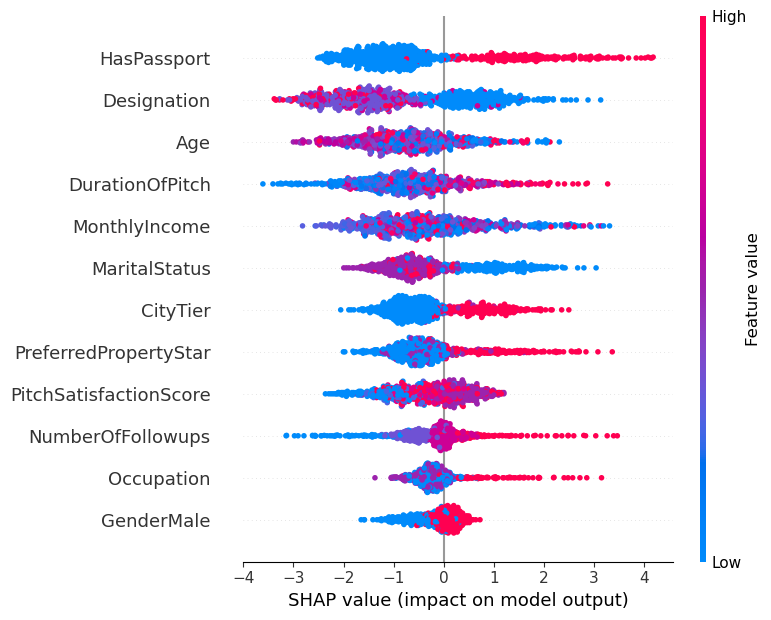

In [284]:
shap.summary_plot(shap_values, X_input)

In [117]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_partial_dependence_with_hue(final_model_calibrated, X, features, grid_resolution=50, figsize=(10,6), 
                                     kind='average', categorical_features = None) :
    fig, ax = plt.subplots(figsize=figsize)  # Set the figure size

    display = PartialDependenceDisplay.from_estimator(
        final_model_calibrated, 
        X, 
        features=features, 
        grid_resolution=grid_resolution, 
        ax=ax, kind=kind, categorical_features=categorical_features
    )

    plt.suptitle("Partial Dependence Plot", size=20)
    plt.tight_layout()
    plt.show()

## 8.3 Partial Dependence Plot

In [101]:
for i, c in enumerate(X_test.columns):
    print([i, c])

[0, 'Age']
[1, 'CityTier']
[2, 'DurationOfPitch']
[3, 'Occupation']
[4, 'GenderMale']
[5, 'NumberOfFollowups']
[6, 'PreferredPropertyStar']
[7, 'MaritalStatus']
[8, 'HasPassport']
[9, 'PitchSatisfactionScore']
[10, 'Designation']
[11, 'MonthlyIncome']


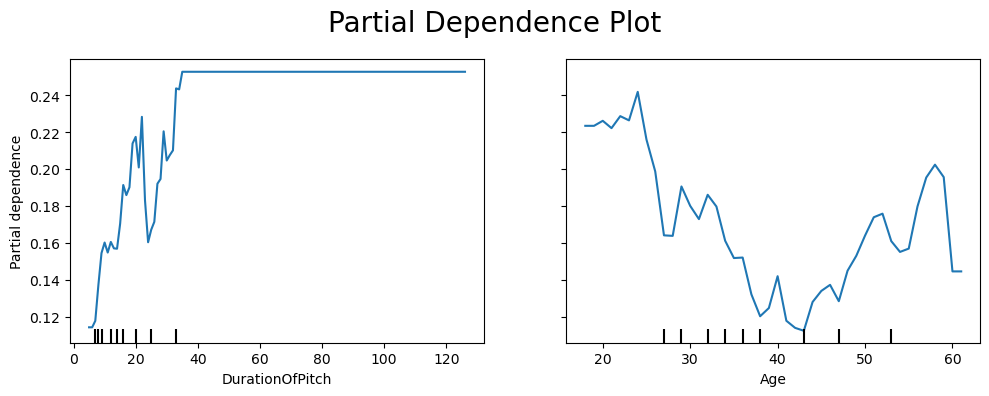

In [144]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [2, 0], grid_resolution=50, figsize=(10, 4))

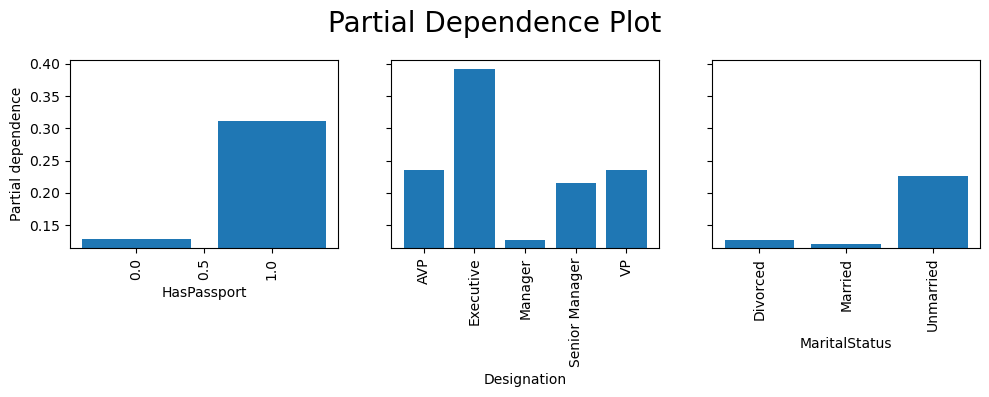

In [128]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [8, 10, 7], grid_resolution=50, figsize=(10, 4), categorical_features=[8, 10, 7])

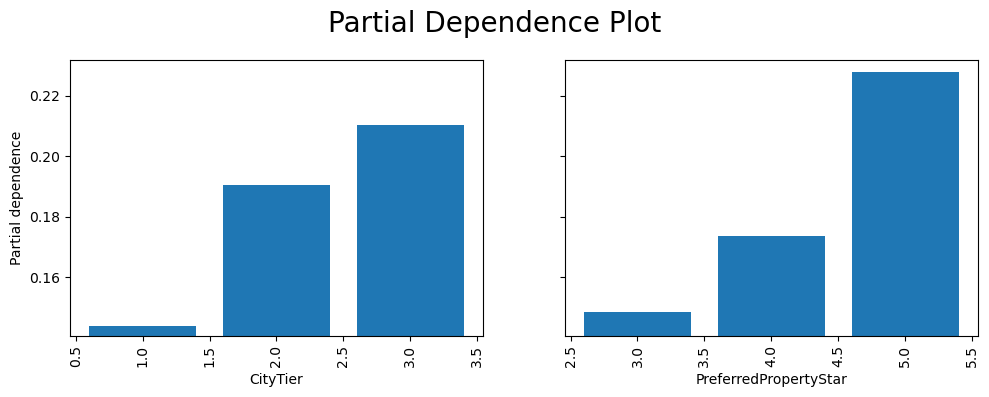

In [129]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [1, 6], grid_resolution=50, figsize=(10, 4), categorical_features=[1, 6])

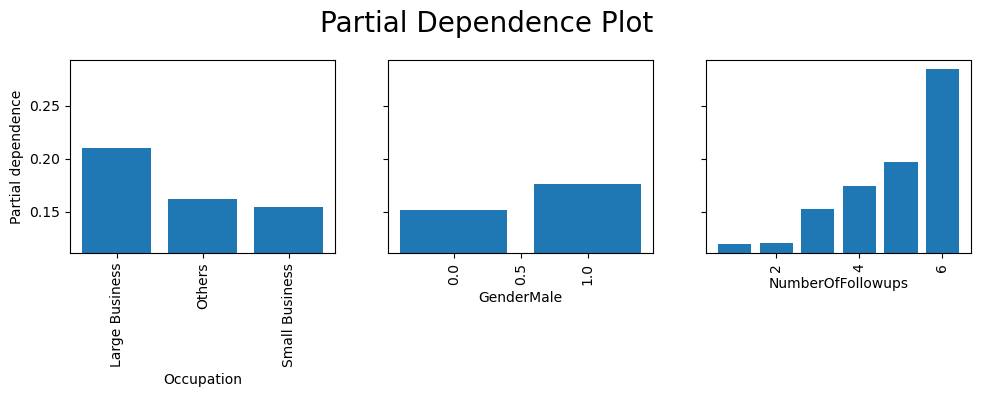

In [131]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [3, 4, 5], grid_resolution=50, figsize=(10, 4), categorical_features=[3,4,5])

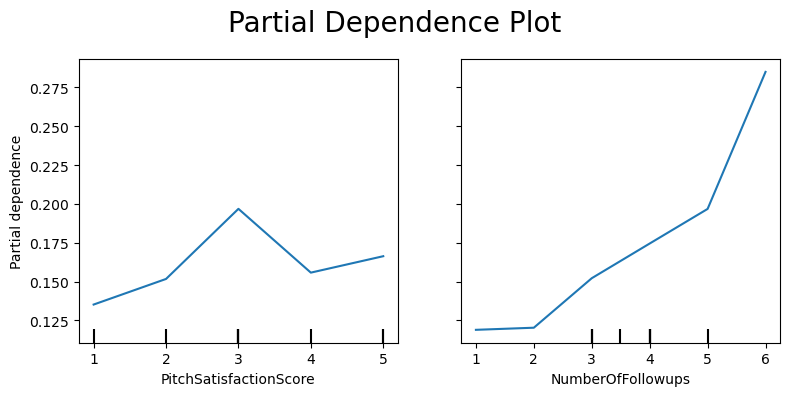

In [146]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [9, 5], grid_resolution=50, figsize=(8, 4))

In [86]:
for i, c in enumerate(X_test.columns):
    print([i, c])

[0, 'Age']
[1, 'CityTier']
[2, 'DurationOfPitch']
[3, 'Occupation']
[4, 'GenderMale']
[5, 'NumberOfFollowups']
[6, 'PreferredPropertyStar']
[7, 'MaritalStatus']
[8, 'HasPassport']
[9, 'PitchSatisfactionScore']
[10, 'Designation']
[11, 'MonthlyIncome']


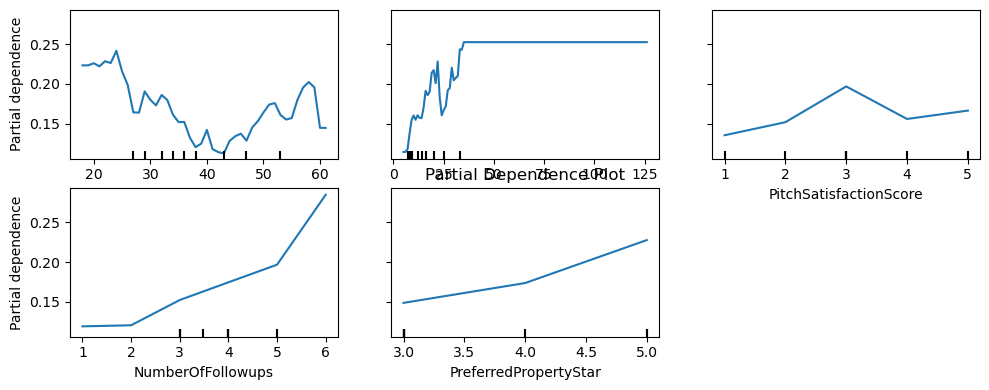

In [289]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [0,2,9,5,6], hue=None, grid_resolution=50, figsize=(10, 4))

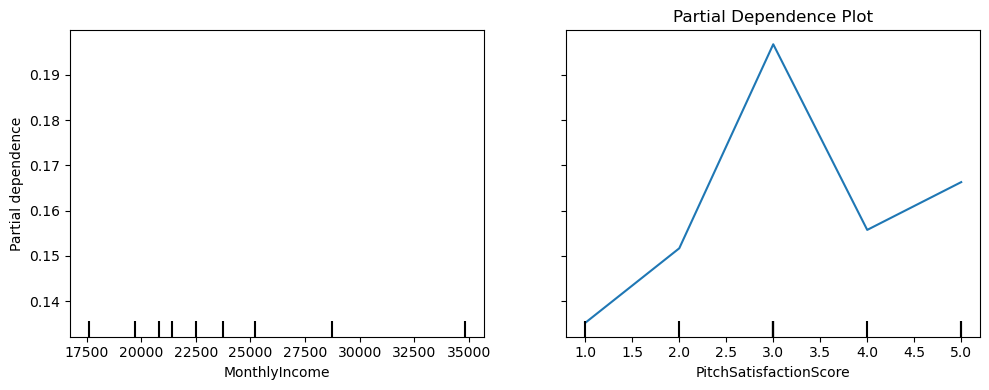

In [290]:
plot_partial_dependence_with_hue(final_model_calibrated, X_test, 
                                 [11,9], hue=None, grid_resolution=50, figsize=(10, 4))

# 9. Model Business Impact

## 9.1 Conversion Rate

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

n_sample = 1000

#split for calibration from training and testing
spliter = StratifiedShuffleSplit(n_splits=1, test_size=n_sample, random_state=seed)
for _index, sample_df_index in spliter.split(full_df, full_df[strat_key]):
    sample_df = full_df.loc[sample_df_index].copy().reset_index(drop=True)

In [8]:
sample_df.to_csv('Data/dummpy_production_df.csv')

In [9]:
sample_df.head()

CustomerID  ProdTaken   Age  CompanyInvited  CityTier  DurationOfPitch  \
0      204365          0  43.0               0         1             31.0   
1      204285          0  30.0               0         1             30.0   
2      203404          0  42.0               1         3              7.0   
3      203982          0  36.0               1         1              7.0   
4      203430          0  40.0               0         3             28.0   

       Occupation  GenderMale  NumberOfFollowups  PreferredPropertyStar  \
0  Small Business           1                4.0                    5.0   
1          Others           1                4.0                    3.0   
2  Small Business           0                4.0                    5.0   
3  Small Business           1                4.0                    5.0   
4          Others           1                5.0                    3.0   

  MaritalStatus  HasPassport  PitchSatisfactionScore     Designation  \
0       Married            1                       1  Senior Manager   
1     Unmarried            0                       3       Executive   
2       Married            0                       3         Manager   
3       Married            0                       1       Executive   
4      Divorced            1                       1         Manager   

   MonthlyIncome  
0        26084.0  
1        20879.0  
2        22781.0  
3        20872.0  
4        24798.0

In [74]:
X = sample_df.drop(columns=drop_cols)
y = sample_df.ProdTaken

In [75]:
y_without_model = sample_df['CompanyInvited']
y_pred = final_model_calibrated.predict(X)

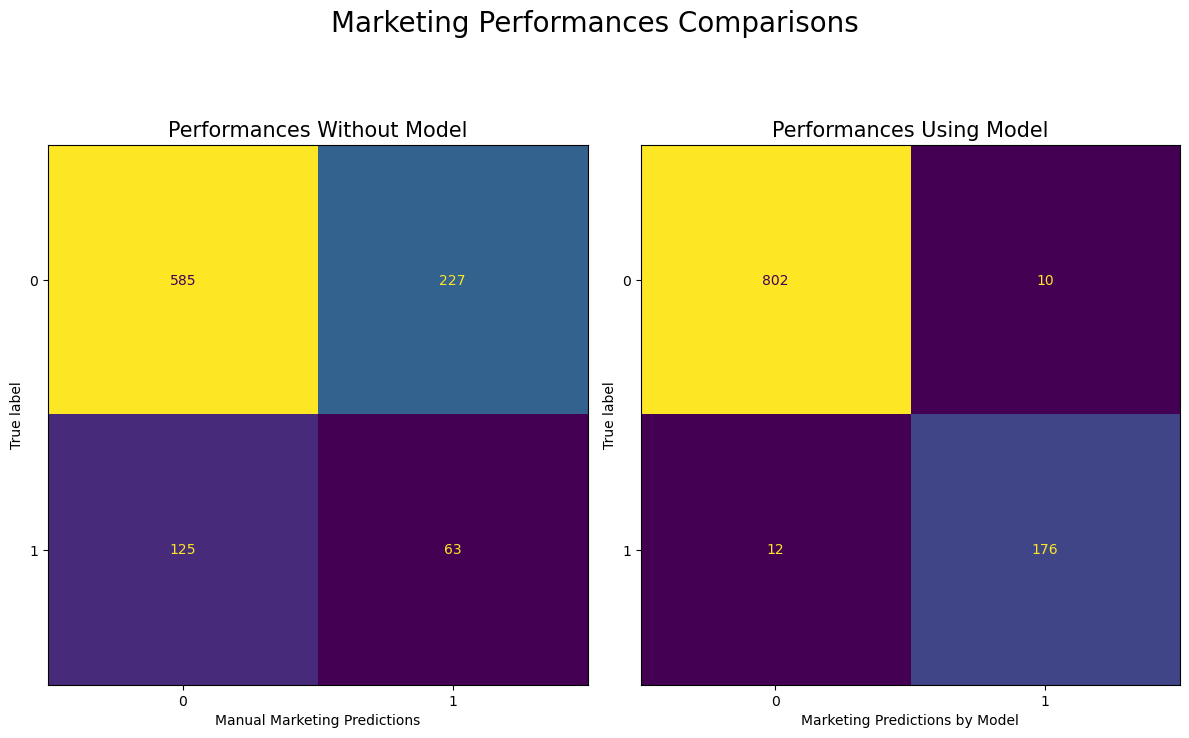

In [76]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax = ax.flatten()

without_model = ConfusionMatrixDisplay.from_predictions(y, y_without_model, ax=ax[0], colorbar = False)
with_model = ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax[1], colorbar = False)

ax[0].set_title("Performances Without Model", size=15)
ax[0].set_xlabel("Manual Marketing Predictions")
ax[1].set_title("Performances Using Model", size=15)
ax[1].set_xlabel("Marketing Predictions by Model")

fig.suptitle("Marketing Performances Comparisons", size=20)
fig.tight_layout()

plt.show();

In [77]:
n_calls_buy_before = 63 #people
n_calls_buy_after = 176 #people
n_calls_notbuy_before = 227 #people
n_calls_notbuy_after = 10 #people

n_calls_before = n_calls_buy_before+n_calls_notbuy_before
n_calls_after = n_calls_buy_after+n_calls_notbuy_after


conv_rate_before = n_calls_buy_before/n_calls_before
conv_rate_after = n_calls_buy_after/n_calls_after

In [78]:
print(f"""
CONVERSION RATE 
The Number of Customer Buy Product of All Contacted Customers
================================================================================================================
**Before Using Model**
Conversion Rate = 100% x Number of Buy from Calls Before Using Model / Total Number of Calss Before Using Model
Conversion Rate = {100*conv_rate_before :.2f}%

================================================================================================================
**After Using Model**
Conversion Rate = Number of Buy from Calls After Using Model / Total Number of Calss After Using Model
Conversion Rate = {100*conv_rate_after :.2f}%

================================================================================================================
The increase of Conversion Rate = (Model Conv. Rate /Prev. Conv. Rate) - 1
The increase of Conversion Rate = {(conv_rate_after / conv_rate_before)-1 :.2f} X More Effective
""")


CONVERSION RATE 
The Number of Customer Buy Product of All Contacted Customers
**Before Using Model**
Conversion Rate = 100% x Number of Buy from Calls Before Using Model / Total Number of Calss Before Using Model
Conversion Rate = 21.72%

**After Using Model**
Conversion Rate = Number of Buy from Calls After Using Model / Total Number of Calss After Using Model
Conversion Rate = 94.62%

The increase of Conversion Rate = (Model Conv. Rate /Prev. Conv. Rate) - 1
The increase of Conversion Rate = 3.36 X More Effective



## 9.2 Customer Acquisition Cost

In [79]:
CPC = 3000 #Rp.
CAC_before = n_calls_before*CPC
CAC_after = n_calls_after*CPC

In [81]:
print(f"""
CUSTOMER ACQUISITION COST / CAC

================================================================
Before Using Models
CAC = Number of Calls Before Using Model * CPC
CAC = Rp. {CAC_before :.2f}

================================================================
After Using Models:
CAC = Number of Calls After Using Model * CPC
CAC = Rp. {CAC_after :.2f}

================================================================
Savings:
Savings = CAC Before - CAC After
Savings = Rp. {CAC_before - CAC_after}

================================================================
%Savings CAC = {100* (1-(CAC_after/CAC_before)) :.2f}%
Savings CAC = Rp. {(1-CAC_after/CAC_before)*CPC :.2f}
""")


CUSTOMER ACQUISITION COST / CAC

Before Using Models
CAC = Number of Calls Before Using Model * CPC
CAC = Rp. 870000.00

After Using Models:
CAC = Number of Calls After Using Model * CPC
CAC = Rp. 558000.00

Savings:
Savings = CAC Before - CAC After
Savings = Rp. 312000

%Savings CAC = 35.86%
Savings CAC = Rp. 1075.86



## 9.3 Contact Rate

With the model probabilities now calibrated, these estimates provide a more reliable prediction of customer willingness to purchase a new product. These probability insights enable the Marketing and Sales teams to enhance their strategies by segmenting customers based on likelihood to purchase and tailoring engagement approaches to align with customer profiles and behaviors

In [82]:
y_pred_proba = final_model_calibrated.predict_proba(X)[:, 1]
y_pred_proba = pd.Series(y_pred_proba)

In [84]:
profiling_df = pd.concat([sample_df,y_pred_proba], axis=1)
profiling_df.rename(columns={0:'PredictionProba'}, inplace=True)
profiling_df.head()

CustomerID  ProdTaken   Age  CompanyInvited  CityTier  DurationOfPitch  \
0      204404          0  39.0               0         1              7.0   
1      201299          0  40.0               0         1              6.0   
2      200687          0  36.0               0         1              8.0   
3      204228          0  40.0               0         1             17.0   
4      203234          0  34.0               0         1             12.0   

       Occupation  GenderMale  NumberOfFollowups  PreferredPropertyStar  \
0          Others           0                4.0                    5.0   
1          Others           0                3.0                    3.0   
2  Small Business           1                3.0                    3.0   
3  Small Business           1                4.0                    5.0   
4          Others           1                5.0                    3.0   

  MaritalStatus  HasPassport  PitchSatisfactionScore     Designation  \
0     Unmarried            0                       1       Executive   
1       Married            0                       3         Manager   
2     Unmarried            0                       5       Executive   
3       Married            1                       3             AVP   
4       Married            0                       3  Senior Manager   

   MonthlyIncome  PredictionProba  
0        21297.0         0.013158  
1        21513.0         0.012048  
2        17519.0         0.013158  
3        35746.0         0.013158  
4        25797.0         0.032967

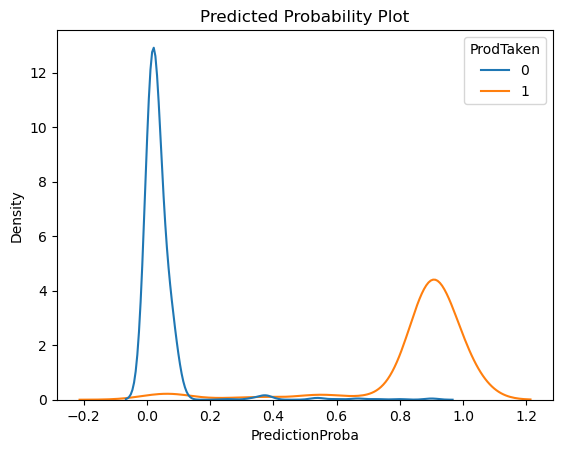

In [85]:
profiling_df.sort_values(by='PredictionProba', ascending=False)

sns.kdeplot(profiling_df, x = 'PredictionProba', hue='ProdTaken', common_norm=False)
plt.title("Predicted Probability Plot")
plt.show();

## 9.4 Enables Marketing and Sales Teams to Know The Reason Why Potential Customers Not Take Product

In [86]:
condition1 = profiling_df['PredictionProba'] >= 0.8
condition2 = profiling_df['ProdTaken'] == 0

MCL = profiling_df[condition1 & condition2].copy()
MCL.rename(columns = {'PredictionProba' : 'Predicted Probability',
                      'ProdTaken' : 'Actual'}, inplace=True)
MCL.Actual = "Not Buy"
MCL["Predicted Probability"] = MCL["Predicted Probability"].apply(lambda x: f"{np.round(100*x, 2)}%")
MCL[["CustomerID", "Predicted Probability", "Actual"]]

CustomerID Predicted Probability   Actual
53       203787                 90.0%  Not Buy
205      203395                 80.0%  Not Buy
672      202482                 90.0%  Not Buy

We Know that from the table, customer with ID `203787`, `203395`, and `202482` are the Potential Customers. But they not take the product. This may be caused by external factor, such as error within systems, they forget about the product, or maybe about the blunder of our teams that might irriate their feelings so they were not take the product.